# Module 5 Individual Project - Predict a diagnosis of Diabetes from Pima Indian data set

Using a data set from the National Institute of Diabetes and Digestive and Kidney Diseases, the objective of the dataset is to predict whether or not a patient will get a Diabetes diagnosis, based on certain clinical measurements included in the dataset. The data resource is https://www.kaggle.com/uciml/pima-indians-diabetes-database.

For this project, we were asked to do the following:
1. Clean up your data set so that you can perform an EDA.

2. Perform EDA to identify opportunities to create new features. 

3. Engineer new features, including at least three non-linear features (polynomial, log transformations, and/or interaction features) and at least three more new features *that are not* interactions or polynomial transformations.

4. Perform feature selection.

5. Fit **four** models to the data and tune **at least two hyperparameters** per model.

6. Decide on which evaluation metric you think is most appropriate for your project, evaluate how well your models perform, and identify your best model.

7. Use the outputs of your different models, along with your EDA work, to provide insight to your original question.

8. Explain how your model can be used to in the real world to solve a problem.   

### Data Overview
The Pima Indian data set contains 768 observations in the data, including eight potential variables and one predictor column called Outcome. Because all colums are the same length, it appears there are no missing data, but the data itself raises questions. For example, why is blood pressure information represented by just one half of the traditional measurement? We are told this is the diastolic pressure, which is the minimum pressure exerted on the walls of the arteries and/or can be thought of as the measurement during the resting or valve filling phase. Normal values are between 60-80 mm Hg, but this data includes values as high as 122 and as low as 0. The latter doesn't medically make sense. Further treatment of the data is necessary.

Having previewed the data statistics on the Kaggle site, the following are additional observations to explore:

**Pregnancies**:  while possible, there are values as high as 17, which will be examined. There are 111 entries of 0, which is indeed possible.

**Glucose**:  A two-hour, 75-gram oral glucose tolerance test (OGTT) is normally used to test for diabetes, which is usually interpreted as a dual measurement, including a fasting level of glucose. The average paired values (fasting, 2-hour) for diabetics is (126mg/dL or greater, 200 mg/dL or greater); for pre-diabetics is (100–125 mg/dL, 140–199 mg/dL); leaving non-diabetics in the ranges of (<100mg/dL, <140mg/dL). There are 5 values of 0 and other values as high as 200.

**Blood Pressure**: Normal values for diastolic blood pressure are between 60-80 mm Hg, but this data set includes values as high as 122 and as low as 0. Further research tells me that normal and elevated are <80 mm Hg.  High blood pressure type 1 is 80-89 and high blood pressure type 2 is above 90.  Hypertensive crisis is considered above 120. Severely low blood pressure (<<40) can deprive your body of enough oxygen to carry out its normal functions, leading to damage to your heart and brain. The zeros don't medically make sense, and probably represent that the data were not collected for these subjects.

**Skin Thickness**:   According to "Chandra Selvi et al in IOSR Journal of Dental and Medical Sciences (IOSR-JDMS)2016, Skin fold thickness measurement provides an estimated size of the subcutaneous fat, which is the layer of subcutaneous tissue and composed of adipocytes. Subcutaneous fat is the major determinant of insulin sensitivity and has a strong association with insulin resistance. Normal is 23mm.  We have 227 values of 0 (30% of the data set.)

**Insulin**:   This measurement is likely a companion measurement to the Glucose test. I will explore options for using the two together.  According to "Melmed S, et al 2011 Williams Textbook of Endocrinology. 12th ed.', blood sugar levels should be less than 80 mg/dl fasting and never rise above 110 or 120 mg/dl after one and two hour checks. Insulin should be less than 5 uIU/mL fasting and should never rise above 30 uIU/mL after one and two-hour checks.

**BMI**:   The formula for BMI is 703 times weight in lbs/height in inches squared. The data set has 11 values of 0.  
 
**DiabetesPedigreeFunction**: This is a measurement of genetic frequency, the calculation of which is unclear. As there are no values of 0, this variable will be explored for outliers and/or used as is. 

**Outcome**: as a binary measurement, we can see that with 500 values of 0, there must be 268 values of 1.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks 
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
ols = linear_model.LinearRegression()
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = [10,5]



# 1. Explore Data (EDA)
The first steps are to familiarize myself with the data, evaluate the state of the data, and establish an initial set of hypotheses.

In [2]:
# Read data
df = pd.read_csv('diabetes.csv')
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
# Check the shape of the data
df.shape

(768, 9)

In [4]:
# Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Numeric summary
df.describe().transpose()

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

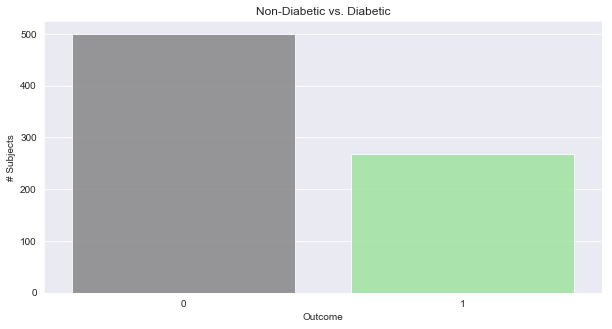

In [6]:
# Target variable count plot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['Outcome'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Non-Diabetic vs. Diabetic')
plt.ylabel('# Subjects')
plt.show()

### First Assessment
Using the describe output, I reviewed the highest and lowest values of each variable as well as the mean and standard deviation to get a feel for the quality and range of the data. This was compared to the expected values from medical literature to help develop hypotheses from the data and to understand where data cleaning is necessary. As a first stage, I need to deal with the zero values and the outliers.  

In [7]:
# count number of zeros in each column
np.sum(df == 0)

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [8]:
# retrieve rows where multiple variables are 0 
df[(df['BloodPressure']==0)&(df['SkinThickness']==0)&(df['Insulin']==0)&(df['BMI']==0)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
49             7      105              0              0        0  0.0   
60             2       84              0              0        0  0.0   
81             2       74              0              0        0  0.0   
426            0       94              0              0        0  0.0   
494            3       80              0              0        0  0.0   
522            6      114              0              0        0  0.0   
706           10      115              0              0        0  0.0   

     DiabetesPedigreeFunction  Age  Outcome  
49                      0.305   24        0  
60                      0.304   21        0  
81                      0.102   22        0  
426                     0.256   25        0  
494                     0.174   22        0  
522                     0.189   26        0  
706                     0.261   30        1

In [9]:
# retrieve rows where multiple variables are 0 
len(df[(df['SkinThickness']==0)&(df['Insulin']==0)])

227

The observations with multiple empty values will be of limited use for the analysis, so these seven rows will be dropped. There are too many observations with SkinThickness and Insulin empty to drop, so these are retained for now.

In [10]:
# Get names of indexes where all selected values are 0
indexNames = df[(df['BloodPressure']==0)&(df['SkinThickness']==0)&(df['Insulin']==0)&(df['BMI']==0)].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [11]:
#verify deletion
df[(df['BloodPressure']==0)&(df['SkinThickness']==0)&(df['Insulin']==0)&(df['BMI']==0)]

Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

### Handling Outliers

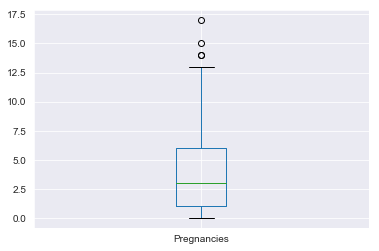

In [12]:
# Handle outliers through box plot visualization
df.boxplot(['Pregnancies'])

In [13]:
# Explore the lower outliers
df[df['Pregnancies']>12]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
28            13      145             82             19      110  22.2   
72            13      126             90              0        0  43.4   
86            13      106             72             54        0  36.6   
88            15      136             70             32      110  37.1   
159           17      163             72             41      114  40.9   
274           13      106             70              0        0  34.2   
298           14      100             78             25      184  36.6   
323           13      152             90             33       29  26.8   
357           13      129              0             30        0  39.9   
455           14      175             62             30        0  33.6   
518           13       76             60              0        0  32.8   
635           13      104             72              0        0  31.2   
691           13      158            114              0        0  42.3   
744           13      153             88             37      140  40.6   

     DiabetesPedigreeFunction  Age  Outcome  
28                      0.245   57        0  
72                      0.583   42        1  
86                      0.178   45        0  
88                      0.153   43        1  
159                     0.817   47        1  
274                     0.251   52        0  
298                     0.412   46        1  
323                     0.731   43        1  
357                     0.569   44        1  
455                     0.212   38        1  
518                     0.180   41        0  
635                     0.465   38        1  
691                     0.257   44        1  
744                     1.174   39        0

While perhaps unusual for a western society, these pregancy numbers are within a plausible sequence. The other data are mostly complete and so the data will be used as is.

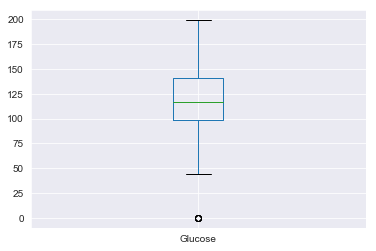

In [14]:
# Handle outliers through box plot visualization
df.boxplot(['Glucose'])

Other than the zero values, the Glucose data appears to have few meaningul outliers. After handling the zero values, the data will be used as provided.

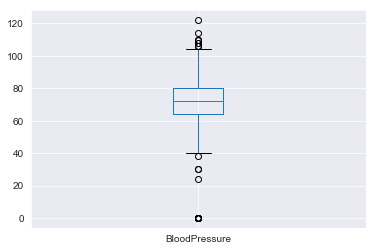

In [15]:
# Handle outliers through box plot visualization
df.boxplot(['BloodPressure'])

In [16]:
# Explore the lower outliers
df[df['BloodPressure'].between(1, 40, inclusive=True)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0      137             40             35      168  43.1   
18             1      103             30             38       83  43.3   
125            1       88             30             42       99  55.0   
597            1       89             24             19       25  27.8   
599            1      109             38             18      120  23.1   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
18                      0.183   33        0  
125                     0.496   26        1  
597                     0.559   21        0  
599                     0.407   26        0

For blood pressure, the zero values will be imputed, and medical information informs us that the high outliers are within valid ranges of high blood pressure.  The numbers below 40 are inconsistent with medical literature, but seeing that two low numbers are adjacent in the data set, I assume that a malfunction or misoperation of blood pressure equipment occurred, and will leave the data in the data set.  The values of 30 are hyper-low, but within a conservative cutoff to the "target" low number of 40.

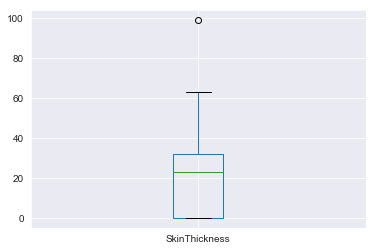

In [17]:
# Handle outliers through box plot visualization
df.boxplot(['SkinThickness'])

In [18]:
df[(df['SkinThickness']>58)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
57             0      100             88             60      110  46.8   
445            0      180             78             63       14  59.4   
579            2      197             70             99        0  34.7   

     DiabetesPedigreeFunction  Age  Outcome  
57                      0.962   31        0  
445                     2.420   25        1  
579                     0.575   62        1

In [19]:
# Remove outliers based on visual inspection
df = df[df['SkinThickness']<70]

The value at 99 is so far from the average and its nearest neighbors, so this observation will be discarded. I assume the study coordinator used 99 as a code.

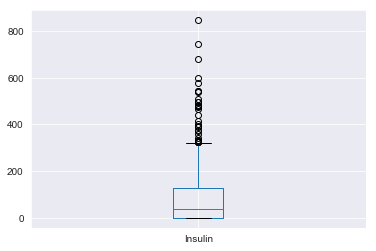

In [20]:
# Handle remaining outliers through box plot visualization
df.boxplot(['Insulin'])

In [21]:
df[(df['Insulin']>400)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
8              2      197             70             45      543  30.5   
13             1      189             60             23      846  30.1   
111            8      155             62             26      495  34.0   
153            1      153             82             42      485  40.6   
186            8      181             68             36      495  30.1   
220            0      177             60             29      478  34.6   
228            4      197             70             39      744  36.7   
247            0      165             90             33      680  52.3   
248            9      124             70             33      402  35.4   
286            5      155             84             44      545  38.7   
370            3      173             82             48      465  38.4   
392            1      131             64             14      415  23.7   
409            1      172             68             49      579  42.4   
415            3      173             84             33      474  35.7   
486            1      139             62             41      480  40.7   
584            8      124             76             24      600  28.7   
645            2      157             74             35      440  39.4   
655            2      155             52             27      540  38.7   
695            7      142             90             24      480  30.4   
753            0      181             88             44      510  43.3   

     DiabetesPedigreeFunction  Age  Outcome  
8                       0.158   53        1  
13                      0.398   59        1  
111                     0.543   46        1  
153                     0.687   23        0  
186                     0.615   60        1  
220                     1.072   21        1  
228                     2.329   31        0  
247                     0.427   23        0  
248                     0.282   34        0  
286                     0.619   34        0  
370                     2.137   25        1  
392                     0.389   21        0  
409                     0.702   28        1  
415                     0.258   22        1  
486                     0.536   21        0  
584                     0.687   52        1  
645                     0.134   30        0  
655                     0.240   25        1  
695                     0.128   43        1  
753                     0.222   26        1

In [22]:
# Your insulin should be less than 5 uIU/mL fasting and should never rise above 30 uIU/mL after one and two-hour checks
df.Insulin.value_counts()


0      366
105     11
140      9
130      9
120      8
100      7
94       7
180      7
110      6
115      6
135      6
66       5
49       5
56       5
76       5
210      5
90       4
88       4
125      4
71       4
200      4
155      4
64       4
160      4
168      4
165      4
54       4
190      4
36       3
182      3
      ... 
191      1
166      1
188      1
184      1
171      1
119      1
255      1
318      1
91       1
310      1
81       1
304      1
300      1
183      1
86       1
291      1
89       1
284      1
280      1
258      1
278      1
277      1
275      1
274      1
272      1
271      1
270      1
108      1
112      1
846      1
Name: Insulin, Length: 186, dtype: int64

I need further study of this variable to determine next steps.

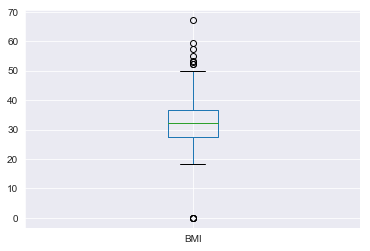

In [23]:
# Handle outliers through box plot visualization
df.boxplot(['BMI'])

In [24]:
df[(df['BMI']>58)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
177            0      129            110             46      130  67.1   
445            0      180             78             63       14  59.4   

     DiabetesPedigreeFunction  Age  Outcome  
177                     0.319   26        1  
445                     2.420   25        1

Other than the BMI values of zero, these values and this data appears complete, and so it will be retained.

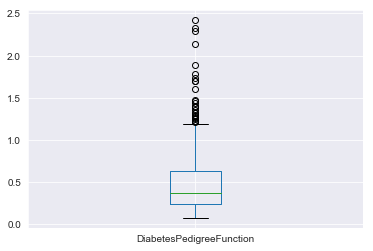

In [25]:
# Handle outliers through box plot visualization
df.boxplot(['DiabetesPedigreeFunction'])

This looks like two different analyses. For now, I will leave the data.

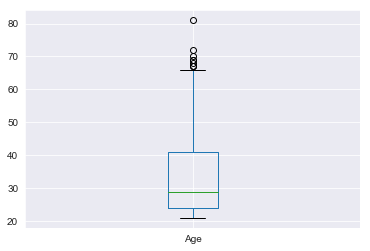

In [26]:
# Handle outliers through box plot visualization
df.boxplot(['Age'])

In [27]:
df[(df['Age']>67)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
123            5      132             80              0        0  26.8   
453            2      119              0              0        0  19.6   
459            9      134             74             33       60  25.9   
666            4      145             82             18        0  32.5   
674            8       91             82              0        0  35.6   
684            5      136             82              0        0   0.0   

     DiabetesPedigreeFunction  Age  Outcome  
123                     0.186   69        0  
453                     0.832   72        0  
459                     0.460   81        0  
666                     0.235   70        1  
674                     0.587   68        0  
684                     0.640   69        0

Again, after review this data is complete and so they will be retained in the data set.

### EDA Interim Analysis
At this point, I have confidently addressed the outliers for all variables except DiabetesPedigreeFunction and Insulin, which need further analysis. For now, the zeros will be addressed, as well as the following:

*Pregnancies*: No changes required.

*Glucose*:  The 5 zero values will be imputed with the mean. It also makes sense to align the data into the three categories:  NonDiabeticRange (<140), PreDiabeticRange (140-199), DiabeticRange (200+), to do later. 

*Blood Pressure*: The 35 values of zero will be imputed to the mean. The other data will be aligned into three categories: LowBP (<=59), NormalBP (60-80), HighBP (>=81), to do later.

*BMI*: The 11 values of zero will be imputed to the mean. 

*Skin Thickness*:  As the data clusters tightly around the mean, the 227 zero values will be imputed to the mean.

*Insulin*: Will convert zero values to NaN to better understand the mean, as I assess further


In [28]:
# set 0 values to NaN to enable appropriate calculation of the means

df[['Glucose','BloodPressure','BMI']] =  df[['Glucose','BloodPressure','BMI']].replace(0, np.NaN)
print(df.isnull().sum())

Pregnancies                  0
Glucose                      5
BloodPressure               28
SkinThickness                0
Insulin                      0
BMI                          4
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64


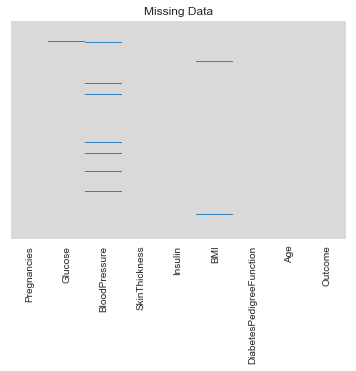

In [29]:
#**Missing Data**  
# A heatmap enables visual confirmation of NaN values
sns.heatmap(df.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

In [30]:
# Imputing with the mean for the variables Glucose, Blood Pressure, and BMI 
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=np.nan, strategy='mean', axis=0)
df[['Glucose','BloodPressure','BMI']] = imputer.fit_transform(df[['Glucose','BloodPressure','BMI']])

In [31]:
# Recalculate summary to verify that mean values changed to reflect actual empirical values
df.describe().transpose()

count        mean         std     min      25%  \
Pregnancies               760.0    3.843421    3.372048   0.000    1.000   
Glucose                   760.0  121.833113   30.330611  44.000  100.000   
BloodPressure             760.0   72.408470   12.159614  24.000   64.000   
SkinThickness             760.0   20.622368   15.657173   0.000    0.000   
Insulin                   760.0   80.639474  115.556654   0.000    0.000   
BMI                       760.0   32.454497    6.910809  18.200   27.500   
DiabetesPedigreeFunction  760.0    0.473993    0.332146   0.078    0.244   
Age                       760.0   33.285526   11.741116  21.000   24.000   
Outcome                   760.0    0.350000    0.477284   0.000    0.000   

                              50%        75%     max  
Pregnancies                 3.000    6.00000   17.00  
Glucose                   118.000  141.00000  199.00  
BloodPressure              72.000   80.00000  122.00  
SkinThickness              23.000   32.00000   63.00  
Insulin                    36.500  129.25000  846.00  
BMI                        32.350   36.60000   67.10  
DiabetesPedigreeFunction    0.377    0.62925    2.42  
Age                        29.000   41.00000   81.00  
Outcome                     0.000    1.00000    1.00

In [32]:
# set 0 values to NaN to enable appropriate calculation of the means

df[['Insulin','SkinThickness']] =  df[['Insulin','SkinThickness']].replace(0, np.NaN)
print(df.isnull().sum())

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               220
Insulin                     366
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [33]:
# Imputing with the mean for SkinThickness 
df[['SkinThickness']] = imputer.fit_transform(df[['SkinThickness']])

In [34]:
# Recalculate summary to verify that mean values changed to reflect actual empirical values
df.describe().transpose()

count        mean         std     min      25%  \
Pregnancies               760.0    3.843421    3.372048   0.000    1.000   
Glucose                   760.0  121.833113   30.330611  44.000  100.000   
BloodPressure             760.0   72.408470   12.159614  24.000   64.000   
SkinThickness             760.0   29.024074    8.464970   7.000   25.000   
Insulin                   394.0  155.548223  118.775855  14.000   76.250   
BMI                       760.0   32.454497    6.910809  18.200   27.500   
DiabetesPedigreeFunction  760.0    0.473993    0.332146   0.078    0.244   
Age                       760.0   33.285526   11.741116  21.000   24.000   
Outcome                   760.0    0.350000    0.477284   0.000    0.000   

                                 50%        75%     max  
Pregnancies                 3.000000    6.00000   17.00  
Glucose                   118.000000  141.00000  199.00  
BloodPressure              72.000000   80.00000  122.00  
SkinThickness              29.024074   32.00000   63.00  
Insulin                   125.000000  190.00000  846.00  
BMI                        32.350000   36.60000   67.10  
DiabetesPedigreeFunction    0.377000    0.62925    2.42  
Age                        29.000000   41.00000   81.00  
Outcome                     0.000000    1.00000    1.00

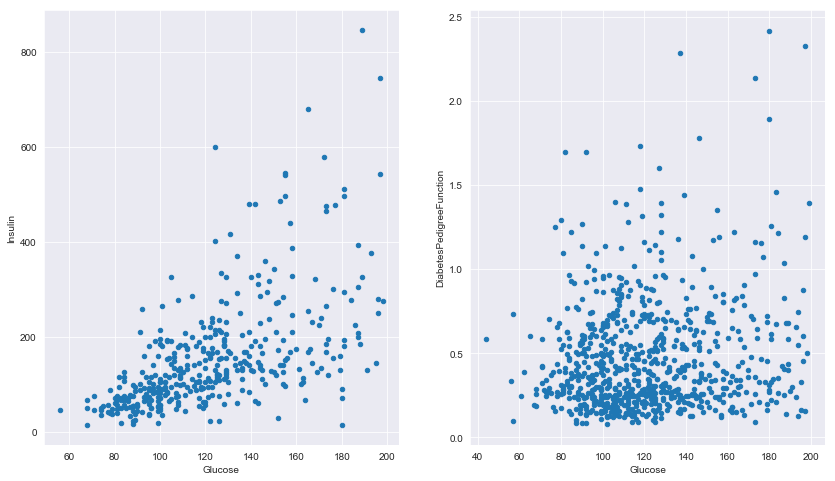

In [35]:
#explore other variables to determine if relationships exist that can be used for handling 0 values
fig, ax =plt.subplots(1,2)
fig.set_size_inches(14,8)
df.plot.scatter(x='Glucose', y='Insulin', ax=ax[0])
df.plot.scatter(x='Glucose', y='DiabetesPedigreeFunction', ax=ax[1])


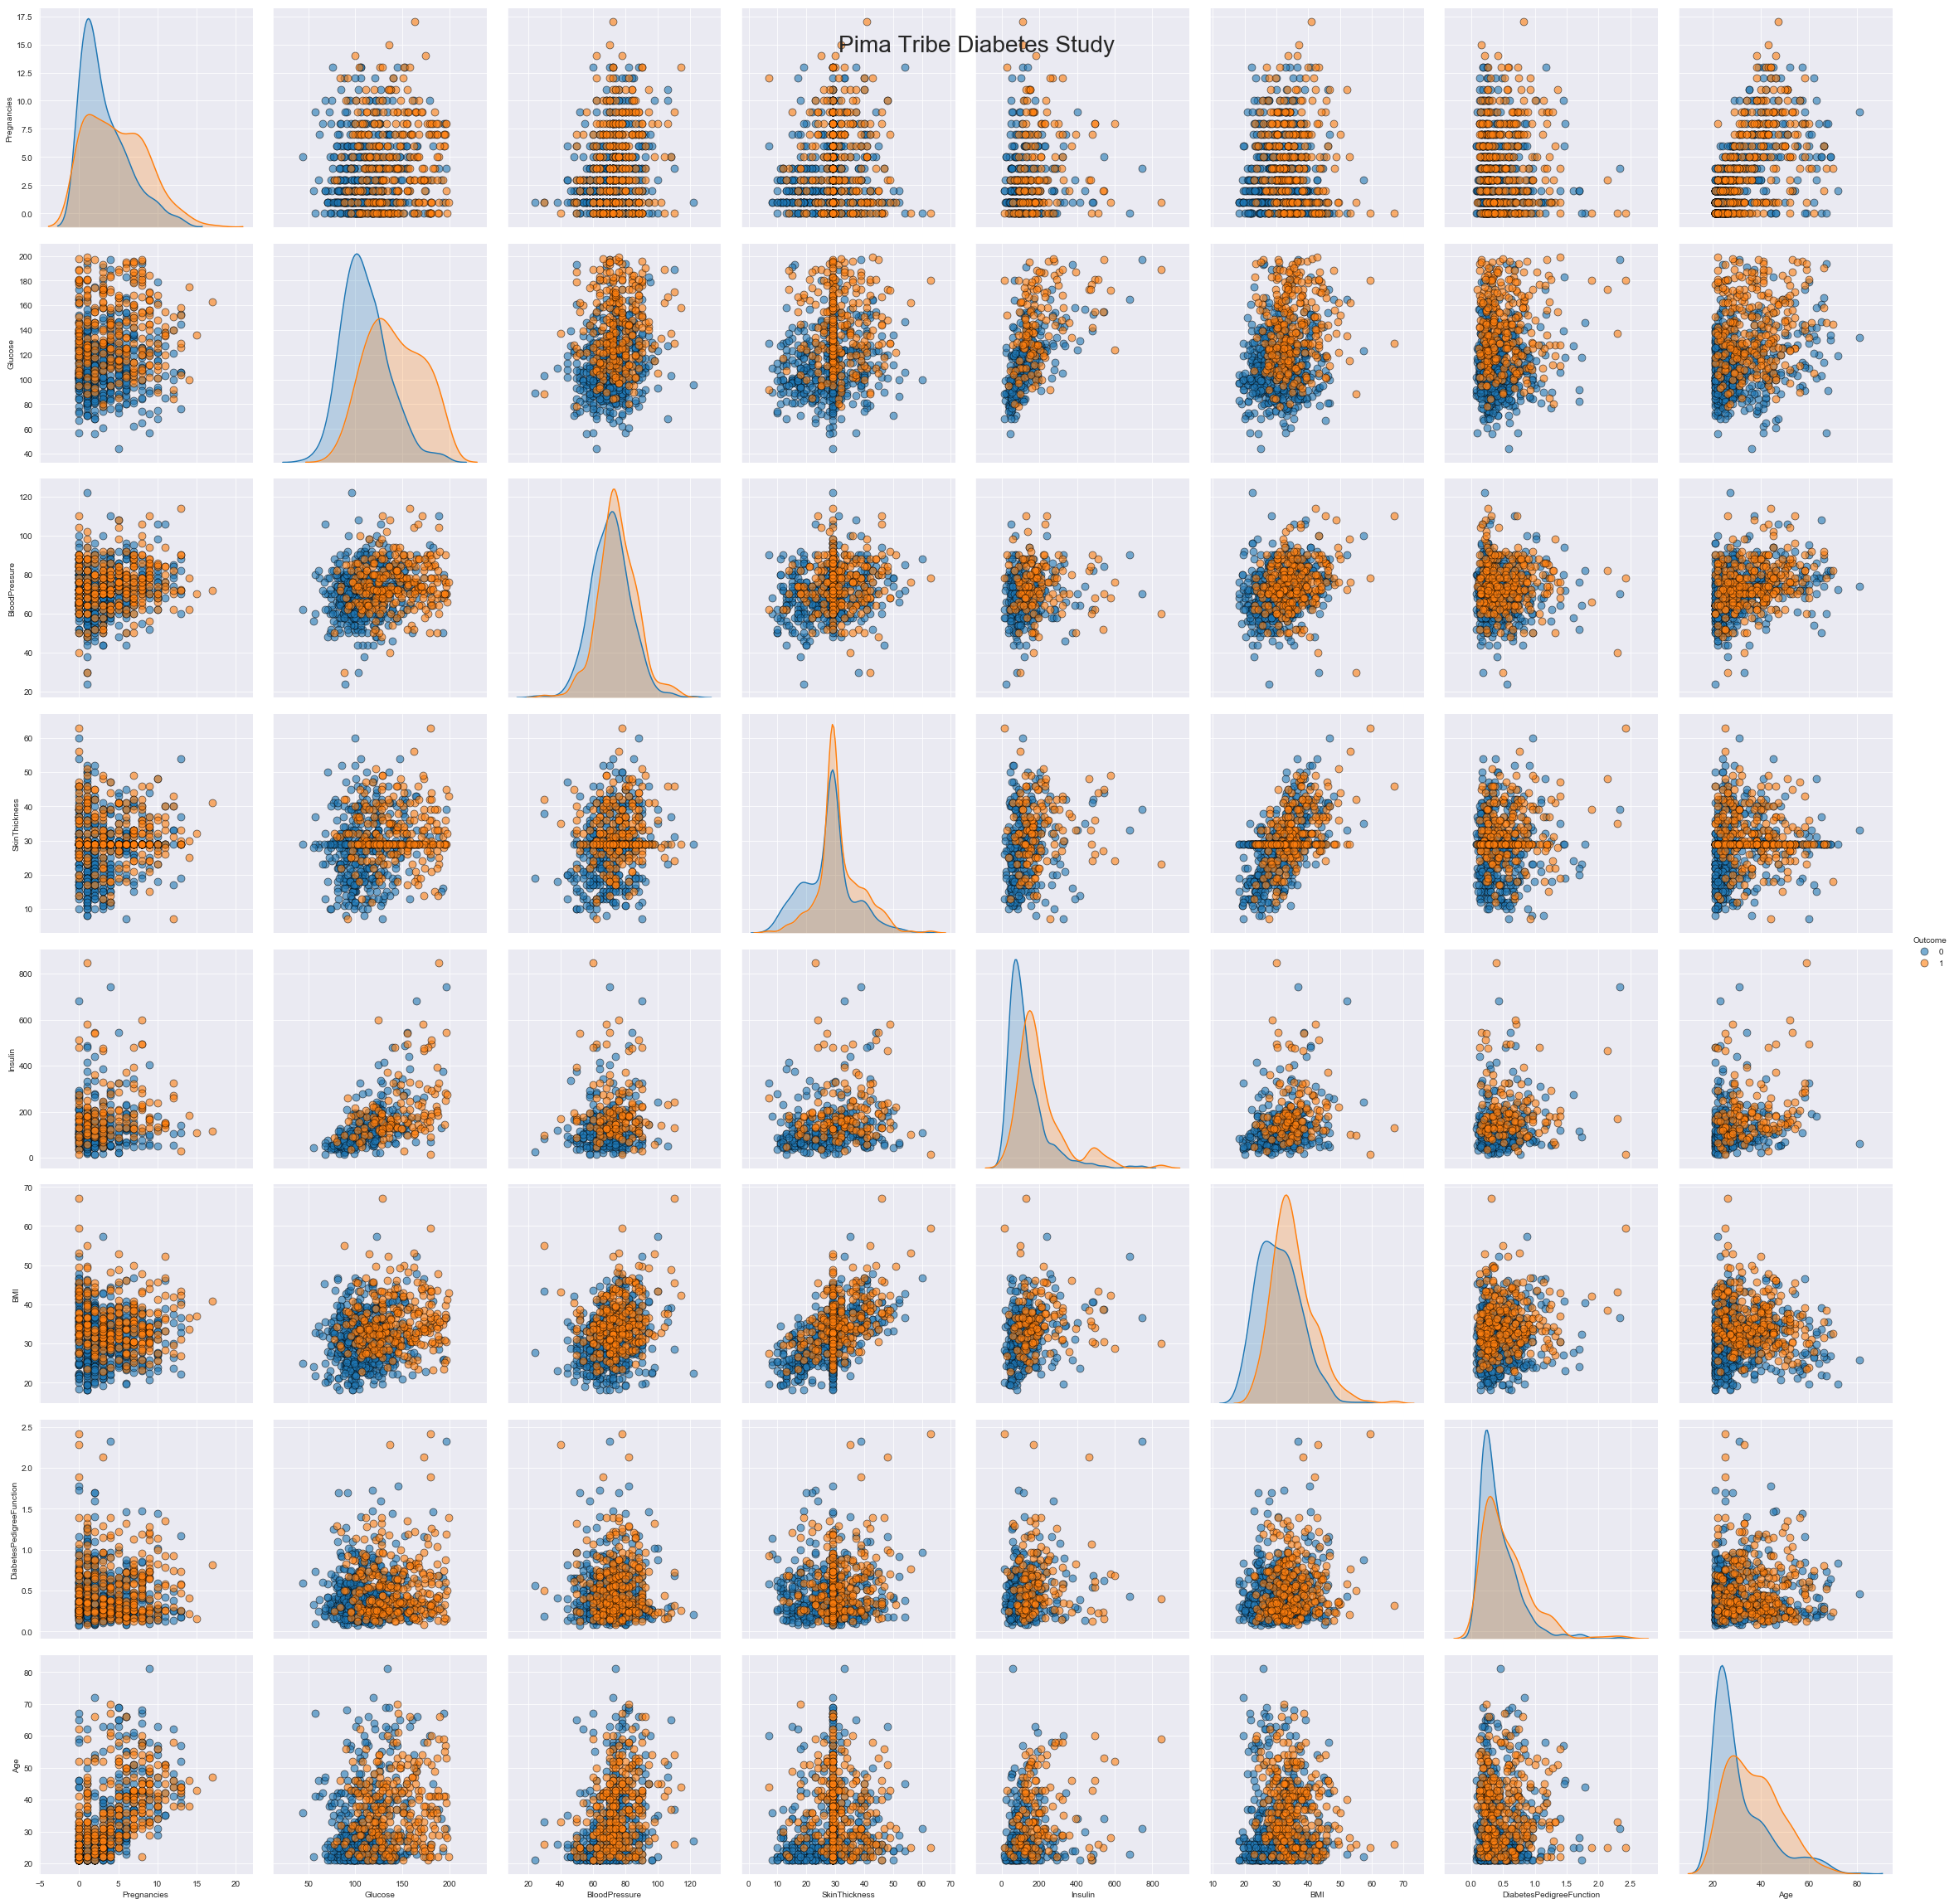

In [36]:
# Vizualize the data after 
sns.pairplot(df[df['Outcome']>=0], 
             vars = ['Pregnancies', 'Glucose', 'BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'], 
             hue = 'Outcome', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4);
# Title 
plt.suptitle('Pima Tribe Diabetes Study', 
             size = 28);

In [163]:
df.corr()

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.128964       0.209327       0.091913   
Glucose                      0.128964  1.000000       0.220917       0.175931   
BloodPressure                0.209327  0.220917       1.000000       0.202611   
SkinThickness                0.091913  0.175931       0.202611       1.000000   
Insulin                      0.082171  0.580334       0.098272       0.184888   
BMI                          0.021898  0.231920       0.281377       0.563439   
DiabetesPedigreeFunction    -0.033117  0.131215      -0.002693       0.103399   
Age                          0.551679  0.255550       0.327477       0.106176   
Outcome                      0.220744  0.489743       0.167193       0.210562   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies               0.082171  0.021898                 -0.033117   
Glucose                   0.580334  0.231920                  0.131215   
BloodPressure             0.098272  0.281377                 -0.002693   
SkinThickness             0.184888  0.563439                  0.103399   
Insulin                   1.000000  0.228082                  0.130395   
BMI                       0.228082  1.000000                  0.153705   
DiabetesPedigreeFunction  0.130395  0.153705                  1.000000   
Age                       0.220261  0.024650                  0.027585   
Outcome                   0.303454  0.312786                  0.171337   

                               Age   Outcome  
Pregnancies               0.551679  0.220744  
Glucose                   0.255550  0.489743  
BloodPressure             0.327477  0.167193  
SkinThickness             0.106176  0.210562  
Insulin                   0.220261  0.303454  
BMI                       0.024650  0.312786  
DiabetesPedigreeFunction  0.027585  0.171337  
Age                       1.000000  0.232301  
Outcome                   0.232301  1.000000

As I try to determine how to impute the Insulin values, the relationship of Glucose and Insulin appears to be the best correlated.  As I view the plot of Diabetic vs. Non-Diabetic, it appears their relationships follow different associations, so I will impute the Insulin values to the respective means.

In [36]:
# Find best mean for each data category
OutcomeN = df[df['Outcome']==0]
OutcomeD = df[df['Outcome']==1]
OutcomeD.Insulin.mean()
OutcomeN.Insulin.mean()

130.28787878787878

In [37]:
# Set mean for the NaN observations for the Diabetic population
df['Insulin'].loc[(df['Insulin'].isna()) & (df['Outcome'] == 1)] = 207

In [38]:
# Set mean for the NaN observations for the Non-Diabetic population
df['Insulin'].loc[(df['Insulin'].isna()) & (df['Outcome'] == 0)] = 130

In [39]:
# Verify that all NaN values in the column were addressed
df[df['Insulin'].isna()]

Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

In [40]:
# Need to reconvert the Insulin feature from type Object to type Integer
df['Insulin']=df['Insulin'].astype(int)

In [253]:
# Recalculate summary to verify that mean values changed to reflect actual empirical values
df.describe().transpose()

count        mean        std     min      25%  \
Pregnancies               760.0    3.843421   3.372048   0.000    1.000   
Glucose                   760.0  121.833113  30.330611  44.000  100.000   
BloodPressure             760.0   72.408470  12.159614  24.000   64.000   
SkinThickness             760.0   29.024074   8.464970   7.000   25.000   
Insulin                   760.0  157.023684  89.301399  14.000  120.000   
BMI                       760.0   32.454497   6.910809  18.200   27.500   
DiabetesPedigreeFunction  760.0    0.473993   0.332146   0.078    0.244   
Age                       760.0   33.285526  11.741116  21.000   24.000   
Outcome                   760.0    0.350000   0.477284   0.000    0.000   

                                 50%        75%     max  
Pregnancies                 3.000000    6.00000   17.00  
Glucose                   118.000000  141.00000  199.00  
BloodPressure              72.000000   80.00000  122.00  
SkinThickness              29.024074   32.00000   63.00  
Insulin                   130.000000  207.00000  846.00  
BMI                        32.350000   36.60000   67.10  
DiabetesPedigreeFunction    0.377000    0.62925    2.42  
Age                        29.000000   41.00000   81.00  
Outcome                     0.000000    1.00000    1.00

In [41]:
# As part of further exploration, create a correlation matrix to assess relationships between the variables
corr_matrix = df.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                       NaN  0.128964       0.209327       0.091913   
Glucose                           NaN       NaN       0.220917       0.175931   
BloodPressure                     NaN       NaN            NaN       0.202611   
SkinThickness                     NaN       NaN            NaN            NaN   
Insulin                           NaN       NaN            NaN            NaN   
BMI                               NaN       NaN            NaN            NaN   
DiabetesPedigreeFunction          NaN       NaN            NaN            NaN   
Age                               NaN       NaN            NaN            NaN   
Outcome                           NaN       NaN            NaN            NaN   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies               0.092786  0.021898                  0.033117   
Glucose                   0.497260  0.231920                  0.131215   
BloodPressure             0.096530  0.281377                  0.002693   
SkinThickness             0.177412  0.563439                  0.103399   
Insulin                        NaN  0.230400                  0.120820   
BMI                            NaN       NaN                  0.153705   
DiabetesPedigreeFunction       NaN       NaN                       NaN   
Age                            NaN       NaN                       NaN   
Outcome                        NaN       NaN                       NaN   

                               Age   Outcome  
Pregnancies               0.551679  0.220744  
Glucose                   0.255550  0.489743  
BloodPressure             0.327477  0.167193  
SkinThickness             0.106176  0.210562  
Insulin                   0.162745  0.410313  
BMI                       0.024650  0.312786  
DiabetesPedigreeFunction  0.027585  0.171337  
Age                            NaN  0.232301  
Outcome                        NaN       NaN

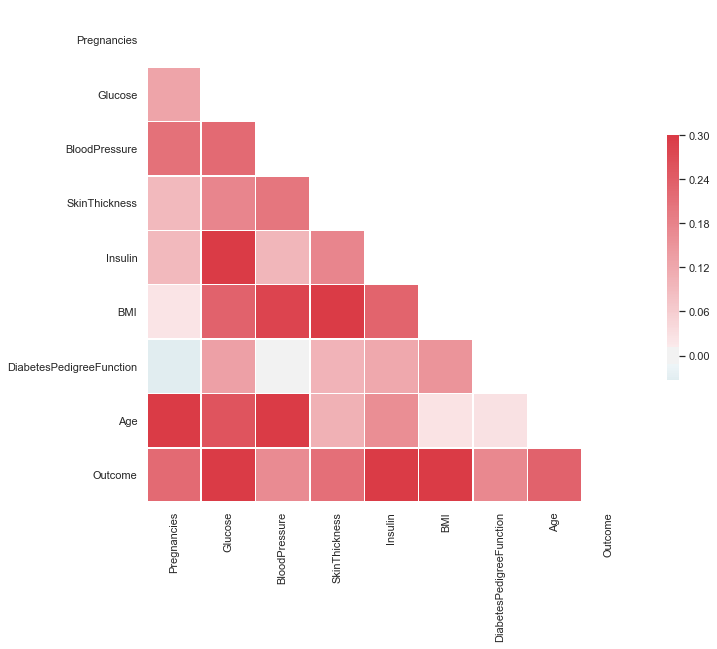

In [42]:
# Numbers are informative, but visualization has more impact, so re-execute the correlation matrix with a heat map

sns.set(style="white")
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### EDA Conclusions 
Having removed outliers and addressed zero values, I have a clean data set on which to proceed with Feature Engineering.  Prior to this, I will run a simple logistic regression to obtain a base model value for comparison to the later model evaluations.

In [43]:
# create a "backup" of the data processed to date.
dfBase = df.copy()

In [257]:
df = dfBase.copy()

## Base Model
It is useful to understand how the "Raw" data may perform in a prediction model, so a logistic regression baseline will be established.

In [44]:
# Train-Test-Split
X = df.drop(['Outcome'], axis = 1)
y = df.Outcome
X_train, X_test ,y_train, y_test = train_test_split(X,y, random_state = 34)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

Training set - Features:  (570, 8) Target:  (570,)
Test set - Features:  (190, 8) Target:  (190,)


In [45]:
# Create instance of model
lreg = LogisticRegression()

# Pass training data into model
lreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
# Predict
y_pred_lreg = lreg.predict(X_test)
# Score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score

# Confusion Matrix
print('Logistic Regression')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_lreg))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test,y_pred_lreg))

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_test, y_pred_lreg) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Logistic Regression


Confusion Matrix
[[103  19]
 [ 27  41]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       122
           1       0.68      0.60      0.64        68

    accuracy                           0.76       190
   macro avg       0.74      0.72      0.73       190
weighted avg       0.75      0.76      0.75       190

--------------------------------------------------------------------------------
Accuracy 75.79 %


In [47]:
# calculate F1 and accuracy through metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)
print('F1', metrics.f1_score(y_test, y_pred_class))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_class))

F1 0.640625
Accuracy 0.7578947368421053


# 2. Feature Engineering
I enter feature engineering with 760 subjects with 8 potential observations each, yielding an accuracy score through a logistic regression model of 75.8% and an F1 score of 75%.

My first feature to engineer is an HbA1c value, a well-established metric for diagnosing diabetes.  The higher an A1C level, the higher risk of developing diabetes or complications of diabetes.

A normal A1C level is below 5.7 percent. A1C levels between 5.7 and 6.4 percent indicate prediabetes (also called impaired fasting glucose), which indicates high risk of developing diabetes in the future. An A1C level of 6.5 percent or higher indicates diabetes. An A1C level above 8 percent means that the diabetes is not well-controlled and the patient has a higher risk of developing complications of diabetes.

The American Diabetes Association’s Web site at www.diabetes.org/ag, provides a formula for this calculation:
28.7 x HbA1c — 46.7 = eAG (in mg/dl). This was used to calculate a new variable.

Other variables will be pursued, such as interaction and polynomials, as well as binning existing variables.

In [48]:
# Create new feature for HbA1C
df['HbA1c'] = ((df['Glucose']+46.7)/28.7)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  
0                     0.627   50        1  6.783972  
1                     0.351   31        0  4.588850  
2                     0.672   32        1  8.003484  
3                     0.167   21        0  4.728223  
4                     2.288   33        1  6.400697

In [49]:
# Define bins for HbA1C
df['A1cNorm'] = (df['HbA1c']<=5.6).astype(int)
df['A1cPre'] = (df['HbA1c'].between(5.5,6.5)).astype(int)
df['A1cDia'] = (df['HbA1c']>=6.5).astype(int)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  A1cNorm  A1cPre  A1cDia  
0                     0.627   50        1  6.783972        0       0       1  
1                     0.351   31        0  4.588850        1       0       0  
2                     0.672   32        1  8.003484        0       0       1  
3                     0.167   21        0  4.728223        1       0       0  
4                     2.288   33        1  6.400697        0       1       0

In [50]:
# Define bins for Glucose
df['GluNorm'] = (df['Glucose']<=140).astype(int)
df['GluPreD'] = (df['Glucose'].between(139,200)).astype(int)
df['GluDia'] = (df['Glucose']>=200).astype(int)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  A1cNorm  A1cPre  A1cDia  \
0                     0.627   50        1  6.783972        0       0       1   
1                     0.351   31        0  4.588850        1       0       0   
2                     0.672   32        1  8.003484        0       0       1   
3                     0.167   21        0  4.728223        1       0       0   
4                     2.288   33        1  6.400697        0       1       0   

   GluNorm  GluPreD  GluDia  
0        0        1       0  
1        1        0       0  
2        0        1       0  
3        1        0       0  
4        1        0       0

In [51]:
# Define bins for Blood Pressure
df['BPLow'] = (df['BloodPressure']<=59).astype(int)
df['BPNorm'] = (df['BloodPressure'].between(59,81)).astype(int)
df['BPHigh'] = (df['BloodPressure']>=81).astype(int)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  A1cNorm  A1cPre  A1cDia  \
0                     0.627   50        1  6.783972        0       0       1   
1                     0.351   31        0  4.588850        1       0       0   
2                     0.672   32        1  8.003484        0       0       1   
3                     0.167   21        0  4.728223        1       0       0   
4                     2.288   33        1  6.400697        0       1       0   

   GluNorm  GluPreD  GluDia  BPLow  BPNorm  BPHigh  
0        0        1       0      0       1       0  
1        1        0       0      0       1       0  
2        0        1       0      0       1       0  
3        1        0       0      0       1       0  
4        1        0       0      1       0       0

In [52]:
# Define bins for BMI
df['BMILow'] = (df['BMI']<=18.5).astype(int)
df['BMINorm'] = (df['BMI'].between(18.5,29)).astype(int)
df['BMIHigh'] = (df['BMI']>=25).astype(int)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  ...  A1cDia  GluNorm  \
0                     0.627   50        1  6.783972  ...       1        0   
1                     0.351   31        0  4.588850  ...       0        1   
2                     0.672   32        1  8.003484  ...       1        0   
3                     0.167   21        0  4.728223  ...       0        1   
4                     2.288   33        1  6.400697  ...       0        1   

   GluPreD  GluDia  BPLow  BPNorm  BPHigh  BMILow  BMINorm  BMIHigh  
0        1       0      0       1       0       0        0        1  
1        0       0      0       1       0       0        1        1  
2        1       0      0       1       0       0        1        0  
3        0       0      0       1       0       0        1        1  
4        0       0      1       0       0       0        0        1  

[5 rows x 22 columns]

In [53]:
# Define bins for Age
df['AgeLow'] = (df['Age']<=26).astype(int)
df['AgeMed'] = (df['Age'].between(26,42)).astype(int)
df['AgeHigh'] = (df['Age']>=42).astype(int)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  ...  GluDia  BPLow  \
0                     0.627   50        1  6.783972  ...       0      0   
1                     0.351   31        0  4.588850  ...       0      0   
2                     0.672   32        1  8.003484  ...       0      0   
3                     0.167   21        0  4.728223  ...       0      0   
4                     2.288   33        1  6.400697  ...       0      1   

   BPNorm  BPHigh  BMILow  BMINorm  BMIHigh  AgeLow  AgeMed  AgeHigh  
0       1       0       0        0        1       0       0        1  
1       1       0       0        1        1       0       1        0  
2       1       0       0        1        0       0       1        0  
3       1       0       0        1        1       1       0        0  
4       0       0       0        0        1       0       1        0  

[5 rows x 25 columns]

In [54]:
# Define bins for SkinThickness
df['SkinLow'] = (df['SkinThickness']<=29).astype(int)
df['SkinHigh'] = (df['SkinThickness']>=30).astype(int)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  ...  BPNorm  BPHigh  \
0                     0.627   50        1  6.783972  ...       1       0   
1                     0.351   31        0  4.588850  ...       1       0   
2                     0.672   32        1  8.003484  ...       1       0   
3                     0.167   21        0  4.728223  ...       1       0   
4                     2.288   33        1  6.400697  ...       0       0   

   BMILow  BMINorm  BMIHigh  AgeLow  AgeMed  AgeHigh  SkinLow  SkinHigh  
0       0        0        1       0       0        1        0         1  
1       0        1        1       0       1        0        1         0  
2       0        1        0       0       1        0        0         0  
3       0        1        1       1       0        0        1         0  
4       0        0        1       0       1        0        0         1  

[5 rows x 27 columns]

In [55]:
# Define bins for Pregnancy
df['PregLow'] = (df['Pregnancies']==0).astype(int)
df['PregNorm'] = (df['Pregnancies'].between(0,7)).astype(int)
df['PregHigh'] = (df['Pregnancies']>=7).astype(int)
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  ...  BMINorm  BMIHigh  \
0                     0.627   50        1  6.783972  ...        0        1   
1                     0.351   31        0  4.588850  ...        1        1   
2                     0.672   32        1  8.003484  ...        1        0   
3                     0.167   21        0  4.728223  ...        1        1   
4                     2.288   33        1  6.400697  ...        0        1   

   AgeLow  AgeMed  AgeHigh  SkinLow  SkinHigh  PregLow  PregNorm  PregHigh  
0       0       0        1        0         1        0         1         0  
1       0       1        0        1         0        0         1         0  
2       0       1        0        0         0        0         0         1  
3       1       0        0        1         0        0         1         0  
4       0       1        0        0         1        1         1         0  

[5 rows x 30 columns]

In [56]:
df['Insulin']=df['Insulin'].astype(int)

### Using skew to determine variables that should be log-transformed
Values of >1 or <-1 are candidates for selection. 

In [57]:
df.skew()

Pregnancies                  0.903825
Glucose                      0.521597
BloodPressure                0.135799
SkinThickness                0.234456
Insulin                      2.610516
BMI                          0.596511
DiabetesPedigreeFunction     1.911334
Age                          1.121523
Outcome                      0.630215
HbA1c                        0.521597
A1cNorm                      0.148063
A1cPre                       0.794162
A1cDia                       1.109018
GluNorm                     -1.148887
GluPreD                      1.047246
GluDia                       0.000000
BPLow                        2.447128
BPNorm                      -0.723240
BPHigh                       1.375075
BMILow                      13.702046
BMINorm                      0.729586
BMIHigh                     -2.085438
AgeLow                       0.465608
AgeMed                       0.185363
AgeHigh                      1.319712
SkinLow                      0.570223
SkinHigh    

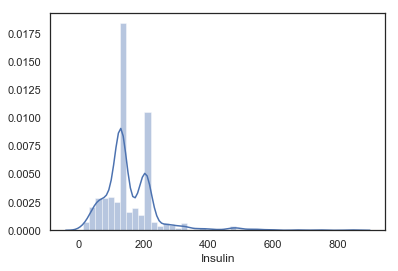

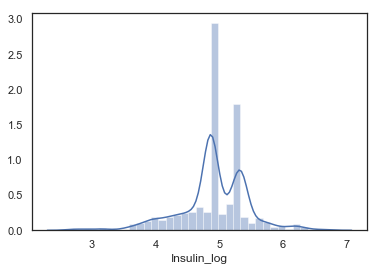

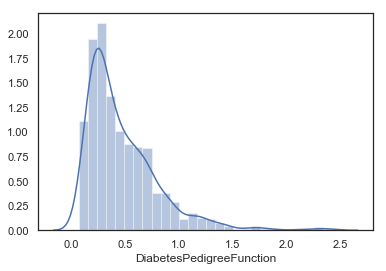

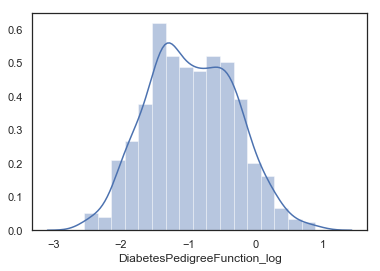

In [58]:
# log transform for fields selected
import seaborn as sns
logcols = ['Insulin','DiabetesPedigreeFunction']
for col in logcols:
    sns.distplot(df[col])
    plt.show()
    df[col+"_log"] = np.log(df[col])
    sns.distplot(df[col+"_log"])
    plt.show()

In [273]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000      207  33.6   
1            1     85.0           66.0      29.000000      130  26.6   
2            8    183.0           64.0      29.024074      207  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome     HbA1c  ...  AgeLow  AgeMed  \
0                     0.627   50        1  6.783972  ...       0       0   
1                     0.351   31        0  4.588850  ...       0       1   
2                     0.672   32        1  8.003484  ...       0       1   
3                     0.167   21        0  4.728223  ...       1       0   
4                     2.288   33        1  6.400697  ...       0       1   

   AgeHigh  SkinLow  SkinHigh  PregLow  PregNorm  PregHigh  Insulin_log  \
0        1        0         1        0         1         0     5.332719   
1        0        1         0        0         1         0     4.867534   
2        0        0         0        0         0         1     5.332719   
3        0        1         0        0         1         0     4.543295   
4        0        0         1        1         1         0     5.123964   

   DiabetesPedigreeFunction_log  
0                     -0.466809  
1                     -1.046969  
2                     -0.397497  
3                     -1.789761  
4                      0.827678  

[5 rows x 32 columns]

### Creating polynomial and interaction variables

In [59]:
features = df.drop(['Outcome','Insulin','DiabetesPedigreeFunction','Pregnancies','Age','SkinThickness'], axis=1)
features.columns

Index(['Glucose', 'BloodPressure', 'BMI', 'HbA1c', 'A1cNorm', 'A1cPre',
       'A1cDia', 'GluNorm', 'GluPreD', 'GluDia', 'BPLow', 'BPNorm', 'BPHigh',
       'BMILow', 'BMINorm', 'BMIHigh', 'AgeLow', 'AgeMed', 'AgeHigh',
       'SkinLow', 'SkinHigh', 'PregLow', 'PregNorm', 'PregHigh', 'Insulin_log',
       'DiabetesPedigreeFunction_log'],
      dtype='object')

In [60]:
#import feature from sklearn to help us create  polynomial features
from sklearn.preprocessing import PolynomialFeatures

#instantiate this class
poly_2 = PolynomialFeatures(degree=2, interaction_only=False)
#fit and transform the data and create a  new dataframe
df_poly_2= pd.DataFrame(poly_2.fit_transform(features), columns=poly_2.get_feature_names(features.columns))
df_poly_2.head()

1  Glucose  BloodPressure   BMI     HbA1c  A1cNorm  A1cPre  A1cDia  \
0  1.0    148.0           72.0  33.6  6.783972      0.0     0.0     1.0   
1  1.0     85.0           66.0  26.6  4.588850      1.0     0.0     0.0   
2  1.0    183.0           64.0  23.3  8.003484      0.0     0.0     1.0   
3  1.0     89.0           66.0  28.1  4.728223      1.0     0.0     0.0   
4  1.0    137.0           40.0  43.1  6.400697      0.0     1.0     0.0   

   GluNorm  GluPreD  ...  PregNorm^2  PregNorm PregHigh  PregNorm Insulin_log  \
0      0.0      1.0  ...         1.0                0.0              5.332719   
1      1.0      0.0  ...         1.0                0.0              4.867534   
2      0.0      1.0  ...         0.0                0.0              0.000000   
3      1.0      0.0  ...         1.0                0.0              4.543295   
4      1.0      0.0  ...         1.0                0.0              5.123964   

   PregNorm DiabetesPedigreeFunction_log  PregHigh^2  PregHigh Insulin_log  \
0                              -0.466809         0.0              0.000000   
1                              -1.046969         0.0              0.000000   
2                              -0.000000         1.0              5.332719   
3                              -1.789761         0.0              0.000000   
4                               0.827678         0.0              0.000000   

   PregHigh DiabetesPedigreeFunction_log  Insulin_log^2  \
0                              -0.000000      28.437890   
1                              -0.000000      23.692892   
2                              -0.397497      28.437890   
3                              -0.000000      20.641527   
4                               0.000000      26.255007   

   Insulin_log DiabetesPedigreeFunction_log  DiabetesPedigreeFunction_log^2  
0                                 -2.489360                        0.217910  
1                                 -5.096158                        1.096144  
2                                 -2.119739                        0.158004  
3                                 -8.131414                        3.203246  
4                                  4.240993                        0.685051  

[5 rows x 378 columns]

### Create Train and Test Split

As part of selecting for the best variables, this process utilizes a train-test split.

In [61]:
df_poly_2.shape

(760, 378)

In [62]:
features = df_poly_2
features.columns

Index(['1', 'Glucose', 'BloodPressure', 'BMI', 'HbA1c', 'A1cNorm', 'A1cPre',
       'A1cDia', 'GluNorm', 'GluPreD',
       ...
       'PregNorm^2', 'PregNorm PregHigh', 'PregNorm Insulin_log',
       'PregNorm DiabetesPedigreeFunction_log', 'PregHigh^2',
       'PregHigh Insulin_log', 'PregHigh DiabetesPedigreeFunction_log',
       'Insulin_log^2', 'Insulin_log DiabetesPedigreeFunction_log',
       'DiabetesPedigreeFunction_log^2'],
      dtype='object', length=378)

In [63]:
target = df.Outcome

In [64]:
#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (608, 378) Target:  (608,)
Training set - Features:  (152, 378) Target:  (152,)


# 3. Feature Selection
I enter feature selection with 378 features. Selection process will leverage multiple tools including removal by correlation coefficient, F-test selection and recursive feature selection.

In [65]:
# scale the data for best effectiveness 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

In [66]:
X_train.head()

1   Glucose  BloodPressure       BMI     HbA1c   A1cNorm   A1cPre  \
0  0.0 -0.796219      -1.018852  0.324226 -0.796219  1.078750 -0.67420   
1  0.0 -0.064228       0.448026 -1.091995 -0.064228 -0.926999  1.48324   
2  0.0 -0.563313      -0.366907 -1.822006 -0.563313  1.078750 -0.67420   
3  0.0 -1.694571       0.448026  0.105223 -1.694571  1.078750 -0.67420   
4  0.0  0.068861      -0.203920 -0.741590  0.068861 -0.926999  1.48324   

     A1cDia   GluNorm   GluPreD  ...  PregNorm^2  PregNorm PregHigh  \
0 -0.590013  0.579883 -0.605221  ...    0.435688          -0.250873   
1 -0.590013  0.579883 -0.605221  ...   -2.295221          -0.250873   
2 -0.590013  0.579883 -0.605221  ...    0.435688          -0.250873   
3 -0.590013  0.579883 -0.605221  ...    0.435688          -0.250873   
4 -0.590013  0.579883 -0.605221  ...    0.435688          -0.250873   

   PregNorm Insulin_log  PregNorm DiabetesPedigreeFunction_log  PregHigh^2  \
0              0.371702                              -1.155306   -0.529150   
1             -2.209792                               1.197623    1.889822   
2              0.414862                              -0.900231   -0.529150   
3             -0.157177                              -0.055853   -0.529150   
4              0.665697                              -0.793440   -0.529150   

   PregHigh Insulin_log  PregHigh DiabetesPedigreeFunction_log  Insulin_log^2  \
0             -0.527072                               0.420421      -0.297175   
1              1.765688                              -1.407350      -0.144516   
2             -0.527072                               0.420421      -0.144516   
3             -0.527072                               0.420421      -1.962293   
4             -0.527072                               0.420421       0.792797   

   Insulin_log DiabetesPedigreeFunction_log  DiabetesPedigreeFunction_log^2  
0                                 -0.938571                        0.967850  
1                                  0.122991                       -0.426556  
2                                 -0.712328                        0.556566  
3                                  0.456165                       -0.468592  
4                                 -0.799626                        0.398376  

[5 rows x 378 columns]

In [67]:
X_train.shape

(608, 378)

In [68]:
# Find index of feature columns with correlation greater than 0.90, and prepare to drop features that meet this.
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
len(to_drop)


172

In [69]:
# Drop the 172 features that are too correlated in the master feature list
#drop feature with high correlation (> 0.90)
features = features.drop(to_drop, axis=1)
features.head()

1  Glucose  BloodPressure   BMI  A1cNorm  A1cPre  A1cDia  GluDia  BPLow  \
0  1.0    148.0           72.0  33.6      0.0     0.0     1.0     0.0    0.0   
1  1.0     85.0           66.0  26.6      1.0     0.0     0.0     0.0    0.0   
2  1.0    183.0           64.0  23.3      0.0     0.0     1.0     0.0    0.0   
3  1.0     89.0           66.0  28.1      1.0     0.0     0.0     0.0    0.0   
4  1.0    137.0           40.0  43.1      0.0     1.0     0.0     0.0    1.0   

   BPNorm  ...  SkinLow DiabetesPedigreeFunction_log  SkinHigh PregLow  \
0     1.0  ...                             -0.000000               0.0   
1     1.0  ...                             -1.046969               0.0   
2     1.0  ...                             -0.000000               0.0   
3     1.0  ...                             -1.789761               0.0   
4     0.0  ...                              0.000000               1.0   

   SkinHigh PregNorm  SkinHigh PregHigh  \
0                1.0                0.0   
1                0.0                0.0   
2                0.0                0.0   
3                0.0                0.0   
4                1.0                0.0   

   SkinHigh DiabetesPedigreeFunction_log  PregLow PregHigh  \
0                              -0.466809               0.0   
1                              -0.000000               0.0   
2                              -0.000000               0.0   
3                              -0.000000               0.0   
4                               0.827678               0.0   

   PregLow DiabetesPedigreeFunction_log  PregNorm PregHigh  \
0                             -0.000000                0.0   
1                             -0.000000                0.0   
2                             -0.000000                0.0   
3                             -0.000000                0.0   
4                              0.827678                0.0   

   PregNorm DiabetesPedigreeFunction_log  \
0                              -0.466809   
1                              -1.046969   
2                              -0.000000   
3                              -1.789761   
4                               0.827678   

   PregHigh DiabetesPedigreeFunction_log  
0                              -0.000000  
1                              -0.000000  
2                              -0.397497  
3                              -0.000000  
4                               0.000000  

[5 rows x 206 columns]

In [70]:
# Also drop feature with high correlation (> 0.90) from the X_train data

X_train_Backup = X_train.copy()

X_train = X_train.drop(to_drop, axis=1)
X_train.head()

1   Glucose  BloodPressure       BMI   A1cNorm   A1cPre    A1cDia  \
0  0.0 -0.796219      -1.018852  0.324226  1.078750 -0.67420 -0.590013   
1  0.0 -0.064228       0.448026 -1.091995 -0.926999  1.48324 -0.590013   
2  0.0 -0.563313      -0.366907 -1.822006  1.078750 -0.67420 -0.590013   
3  0.0 -1.694571       0.448026  0.105223  1.078750 -0.67420 -0.590013   
4  0.0  0.068861      -0.203920 -0.741590 -0.926999  1.48324 -0.590013   

   GluDia     BPLow    BPNorm  ...  SkinLow DiabetesPedigreeFunction_log  \
0     0.0 -0.357792  0.697533  ...                             -2.167031   
1     0.0 -0.357792  0.697533  ...                              0.566056   
2     0.0 -0.357792  0.697533  ...                             -1.870744   
3     0.0 -0.357792  0.697533  ...                              0.566056   
4     0.0 -0.357792  0.697533  ...                             -1.746699   

   SkinHigh PregLow  SkinHigh PregNorm  SkinHigh PregHigh  \
0         -0.243379          -0.630636          -0.309023   
1         -0.243379          -0.630636          -0.309023   
2         -0.243379          -0.630636          -0.309023   
3         -0.243379           1.585702          -0.309023   
4         -0.243379          -0.630636          -0.309023   

   SkinHigh DiabetesPedigreeFunction_log  PregLow PregHigh  \
0                               0.541697               0.0   
1                               0.541697               0.0   
2                               0.541697               0.0   
3                              -0.991546               0.0   
4                               0.541697               0.0   

   PregLow DiabetesPedigreeFunction_log  PregNorm PregHigh  \
0                              0.335046          -0.250873   
1                              0.335046          -0.250873   
2                             -3.183649          -0.250873   
3                              0.335046          -0.250873   
4                             -3.004531          -0.250873   

   PregNorm DiabetesPedigreeFunction_log  \
0                              -1.155306   
1                               1.197623   
2                              -0.900231   
3                              -0.055853   
4                              -0.793440   

   PregHigh DiabetesPedigreeFunction_log  
0                               0.420421  
1                              -1.407350  
2                               0.420421  
3                               0.420421  
4                               0.420421  

[5 rows x 206 columns]

In [71]:
# From the down-sized feature list, use the F-test to select the 8 best features

from sklearn.feature_selection import SelectKBest, f_classif,f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV

selector = SelectKBest(f_classif, k=10)
selector.fit(X_train, y_train)
best_columns = X_train.columns[selector.get_support()]
other_columns = X_train.columns[~selector.get_support()]


In [72]:
best_columns

Index(['Glucose', 'A1cNorm', 'A1cDia', 'Insulin_log', 'Glucose BloodPressure',
       'Glucose BMI', 'Glucose BMIHigh', 'BMI Insulin_log',
       'A1cNorm DiabetesPedigreeFunction_log', 'GluNorm PregNorm'],
      dtype='object')

In [73]:
# Drop the non-selected features from the X_train and Features list
X_train_Backup2 = X_train.copy()

features = features.drop(other_columns, axis=1)
X_train = X_train.drop(other_columns, axis=1)
X_train.head()

Glucose   A1cNorm    A1cDia  Insulin_log  Glucose BloodPressure  \
0 -0.796219  1.078750 -0.590013    -0.237810              -1.017256   
1 -0.064228 -0.926999 -0.590013    -0.086852               0.139534   
2 -0.563313  1.078750 -0.590013    -0.086852              -0.598418   
3 -1.694571  1.078750 -0.590013    -2.087615              -1.130941   
4  0.068861 -0.926999 -0.590013     0.790467              -0.086506   

   Glucose BMI  Glucose BMIHigh  BMI Insulin_log  \
0    -0.415639        -0.186877         0.140518   
1    -0.690635         0.249848        -0.939989   
2    -1.308450        -2.132290        -1.531764   
3    -1.131892        -0.722858        -0.825882   
4    -0.417698         0.329253        -0.346015   

   A1cNorm DiabetesPedigreeFunction_log  GluNorm PregNorm  
0                             -1.686239          0.742307  
1                              0.714838         -1.347151  
2                             -1.425944          0.742307  
3                             -0.564288          0.742307  
4                              0.714838          0.742307

In [74]:
# Use recursive feature elimination based on the linear regression model to identify additional features

ols = linear_model.LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.support_]
removed_columns = X_train.columns[~selector.support_]


In [75]:
len(list(selected_columns))

9

In [76]:
selected_columns

Index(['Glucose', 'A1cNorm', 'A1cDia', 'Insulin_log', 'Glucose BMI',
       'Glucose BMIHigh', 'BMI Insulin_log',
       'A1cNorm DiabetesPedigreeFunction_log', 'GluNorm PregNorm'],
      dtype='object')

Concerned that the imputing of Insulin will bias the model, I am removing the Insulin columns from the Features list.

In [77]:
removed_columns

Index(['Glucose BloodPressure'], dtype='object')

In [78]:
new_removed_columns = ['Glucose BloodPressure', 'Insulin_log', 'BMI Insulin_log']

In [79]:
# Retain only the selected features from the X_train and Features list
X_train_Backup3 = X_train.copy()

features = features.drop(new_removed_columns, axis=1)
X_train = X_train.drop(new_removed_columns, axis=1)
X_train.head()

Glucose   A1cNorm    A1cDia  Glucose BMI  Glucose BMIHigh  \
0 -0.796219  1.078750 -0.590013    -0.415639        -0.186877   
1 -0.064228 -0.926999 -0.590013    -0.690635         0.249848   
2 -0.563313  1.078750 -0.590013    -1.308450        -2.132290   
3 -1.694571  1.078750 -0.590013    -1.131892        -0.722858   
4  0.068861 -0.926999 -0.590013    -0.417698         0.329253   

   A1cNorm DiabetesPedigreeFunction_log  GluNorm PregNorm  
0                             -1.686239          0.742307  
1                              0.714838         -1.347151  
2                             -1.425944          0.742307  
3                             -0.564288          0.742307  
4                              0.714838          0.742307

In [80]:
X_train.columns

Index(['Glucose', 'A1cNorm', 'A1cDia', 'Glucose BMI', 'Glucose BMIHigh',
       'A1cNorm DiabetesPedigreeFunction_log', 'GluNorm PregNorm'],
      dtype='object')

### Feature Selection Analysis:
I entered feature selection with 378 features. Using correlation, I eliminated 172 features that showed >0.9 correlation. With F-test, I further downselected to the 8 best features. Using recursive feature selection following that, 9 features were selected. I further removed 2 features that included the Insulin feature, leaving 7 features that will be used.

In [81]:
# Because we removed features during feature selection - perform test/train split and scaling again:

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34,test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=features.columns)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=features.columns)

In [82]:
#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (608, 7) Target:  (608,)
Training set - Features:  (152, 7) Target:  (152,)


### Resample to Limit Bias:
When the predictor used to train the model is unbalanced in terms of observations of yes and no, when we fit out model it will generally predict the majority class more often than it should. We resample to limit this bias.

In [83]:
y_train= pd.DataFrame(y_train, columns=['Outcome'])

In [84]:
# separate minority and majority classes
NonDiabetic = pd.DataFrame(y_train[y_train['Outcome']==0])
Diabetic = pd.DataFrame(y_train[y_train['Outcome']==1])

# Get a class count to understand the class imbalance.
print('NonDiabetic: '+ str(len(NonDiabetic)))
print('Diabetic: '+ str(len(Diabetic)))

NonDiabetic: 396
Diabetic: 212


In [85]:
# Smote for upsampling the minority

sm = SMOTE(random_state=23, ratio=1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

#fit Model to resampled data

knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train_sm, y_train_sm)

y_pred_class = knn.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_class))

X_train = X_train_sm 
y_train = y_train_sm 

Test Accuracy score:  0.631578947368421
Test F1 score:  0.5942028985507246


# 3. Fit Models
I will use Logistic Regression, KNN, Decision Tree, Random Forest, and XG Boost,

### Logistic Regression

In [86]:
# Create instance of model
lreg = LogisticRegression()

# Pass training data into model
lreg.fit(X_train, y_train)

# Predict
y_pred_lreg = lreg.predict(X_test)

# Score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score

# Confusion Matrix
print('Logistic Regression')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_lreg))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test,y_pred_lreg))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_lreg))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_lreg))

Logistic Regression


Confusion Matrix
[[70 28]
 [13 41]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        98
           1       0.59      0.76      0.67        54

    accuracy                           0.73       152
   macro avg       0.72      0.74      0.72       152
weighted avg       0.75      0.73      0.74       152

--------------------------------------------------------------------------------
F1 0.6666666666666666
Accuracy 0.7302631578947368


### Logistic Regression Results:
The model delivered and F1 score of 66.6%, which performed better than the base model at 64.1%. However, one change was executed between these tests (resampling to limit bias that may have arisen from an inbalanced representation of the Outcome.)

### **K-NEAREST NEIGHBORS**   

K-Nearest Neighbors (KNN) is used to classify new data points based on ‘distance’ to known data on a scatter plot with a two step process: 
1.  Find K nearest neighbors based on your distance metric
2.  Let them all vote on the classification 

In [87]:
# Create instance of model
knn = KNeighborsClassifier(n_neighbors = 1)

# Fit to training data
knn.fit(X_train,y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Score it
print('K-Nearest Neighbors (KNN)')
print('k = 1')
print('\n')
# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred_knn))

# Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_knn))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_knn))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_knn))

K-Nearest Neighbors (KNN)
k = 1


Confusion Matrix
[[72 26]
 [22 32]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        98
           1       0.55      0.59      0.57        54

    accuracy                           0.68       152
   macro avg       0.66      0.66      0.66       152
weighted avg       0.69      0.68      0.69       152

--------------------------------------------------------------------------------
F1 0.5714285714285714
Accuracy 0.6842105263157895


#### KNN Parameter Tuning 
With a precision of 57.1%, the model's performance using k = 1 might be improved by choosing a better k value.  

The best way to identify the optimal k value is with the 'Elbow' method, which interates many models using different k values and plots their error rates. The k with the lowest error rate is the optimal value we want to use.  

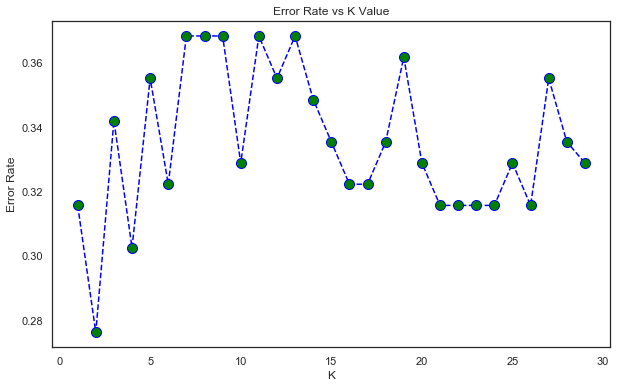

In [94]:
# Function
error_rate = []

for i in range (1,30):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# Plot error rate
plt.figure(figsize = (10,6))
plt.plot(range(1,30), error_rate, color = 'blue', linestyle = '--', marker = 'o', 
        markerfacecolor = 'green', markersize = 10)

plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

From the graph above, the best K value for this model appears to be K=2, so this will be pursued in tuning.

In [95]:
# Fit new KNN
# Create model object
knn = KNeighborsClassifier(n_neighbors = 2, p=1)

# Fit new KNN on training data
knn.fit(X_train, y_train)

# Predict new KNN
y_pred_knn_op = knn.predict(X_test)

# Score it with new KNN
print('K-Nearest Neighbors(KNN)')
print('k = 2')

# Confusion Matrix
print('\n')
print(confusion_matrix(y_test, y_pred_knn_op))

# Classification Report
print('--'*40)
print('Classfication Report',classification_report(y_test, y_pred_knn_op))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_knn_op))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_knn_op))

K-Nearest Neighbors(KNN)
k = 2


[[80 18]
 [27 27]]
--------------------------------------------------------------------------------
Classfication Report               precision    recall  f1-score   support

           0       0.75      0.82      0.78        98
           1       0.60      0.50      0.55        54

    accuracy                           0.70       152
   macro avg       0.67      0.66      0.66       152
weighted avg       0.70      0.70      0.70       152

--------------------------------------------------------------------------------
F1 0.5454545454545454
Accuracy 0.7039473684210527


I want to adjust the p parameter, to utilize the Manhattan distance, rather than the Euclidean distance in the calculation. This will be varied in the next iteration.

In [97]:
# Fit new KNN
# Create model object
knn = KNeighborsClassifier(n_neighbors = 2, p=2)

# Fit new KNN on training data
knn.fit(X_train, y_train)

# Predict new KNN
y_pred_knn_op2 = knn.predict(X_test)

# Score it with new KNN
print('K-Nearest Neighbors(KNN)')
print('k = 4')

# Confusion Matrix
print('\n')
print(confusion_matrix(y_test, y_pred_knn_op2))

# Classification Report
print('--'*40)
print('Classfication Report',classification_report(y_test, y_pred_knn_op2))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_knn_op2))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_knn_op2))

K-Nearest Neighbors(KNN)
k = 4


[[84 14]
 [28 26]]
--------------------------------------------------------------------------------
Classfication Report               precision    recall  f1-score   support

           0       0.75      0.86      0.80        98
           1       0.65      0.48      0.55        54

    accuracy                           0.72       152
   macro avg       0.70      0.67      0.68       152
weighted avg       0.71      0.72      0.71       152

--------------------------------------------------------------------------------
F1 0.553191489361702
Accuracy 0.7236842105263158


I will now use the GridSearch to automatically cycle through hyperparameters to find best performing ones for the model.

In [98]:
#creating our parameters to test
parameters = {'n_neighbors':[14,1,5,4,19],
              'weights':['uniform', 'distance'], 
              'leaf_size':[15,30],
               'p':[1,2]}

#create our estimator
knn = KNeighborsClassifier(metric='euclidean')

#create the instance of GridSearchCV
grid_knn=GridSearchCV(estimator = knn, param_grid=parameters, cv=5, scoring='f1', verbose=2)

#fit the Gridsearch to our data
grid_knn.fit(X_train, y_train)

#examine the best model   
#single best score achieved across all params (min_samples_split)
print(grid_knn.best_score_)

#dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_knn.best_params_)

#predict the response for test dataset
y_pred_knn_opp3 = grid_knn.best_estimator_.predict(X_test)

#model accuracy
print("F1:",metrics.f1_score(y_test, y_pred_knn_opp3))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] leaf_size=15, n_neighbors=14, p=1, weights=uniform ..............
[CV]  leaf_size=15, n_neighbors=14, p=1, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=14, p=1, weights=uniform ..............
[CV]  leaf_size=15, n_neighbors=14, p=1, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=14, p=1, weights=uniform ..............
[CV]  leaf_size=15, n_neighbors=14, p=1, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=14, p=1, weights=uniform ..............
[CV]  leaf_size=15, n_neighbors=14, p=1, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=14, p=1, weights=uniform ..............
[CV]  leaf_size=15, n_neighbors=14, p=1, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=14, p=1, weights=distance .............
[CV]  leaf_size=15, n_neighbors=14, p=1, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=14, p=1, weights=distance .............
[CV]  le

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  leaf_size=15, n_neighbors=1, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=1, p=2, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=1, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=1, p=2, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=1, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=1, p=2, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=1, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=1, p=2, weights=distance ..............
[CV]  leaf_size=15, n_neighbors=1, p=2, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=1, p=2, weights=distance ..............
[CV]  leaf_size=15, n_neighbors=1, p=2, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=1, p=2, weights=distance ..............
[CV]  leaf_size=15, n_neighbors=1, p=2, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=1, p=2, weights=distance ..............
[CV

[CV]  leaf_size=15, n_neighbors=19, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=15, n_neighbors=19, p=2, weights=distance .............
[CV]  leaf_size=15, n_neighbors=19, p=2, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=19, p=2, weights=distance .............
[CV]  leaf_size=15, n_neighbors=19, p=2, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=19, p=2, weights=distance .............
[CV]  leaf_size=15, n_neighbors=19, p=2, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=19, p=2, weights=distance .............
[CV]  leaf_size=15, n_neighbors=19, p=2, weights=distance, total=   0.0s
[CV] leaf_size=15, n_neighbors=19, p=2, weights=distance .............
[CV]  leaf_size=15, n_neighbors=19, p=2, weights=distance, total=   0.0s
[CV] leaf_size=30, n_neighbors=14, p=1, weights=uniform ..............
[CV]  leaf_size=30, n_neighbors=14, p=1, weights=uniform, total=   0.0s
[CV] leaf_size=30, n_neighbors=14, p=1, weights=uniform .........

[CV]  leaf_size=30, n_neighbors=5, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=30, n_neighbors=5, p=2, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=5, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=30, n_neighbors=5, p=2, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=5, p=2, weights=uniform, total=   0.0s
[CV] leaf_size=30, n_neighbors=5, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=5, p=2, weights=distance, total=   0.0s
[CV] leaf_size=30, n_neighbors=5, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=5, p=2, weights=distance, total=   0.0s
[CV] leaf_size=30, n_neighbors=5, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=5, p=2, weights=distance, total=   0.0s
[CV] leaf_size=30, n_neighbors=5, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=5, p=2, weights=distance, total=   0.0s
[CV] leaf_size=30, n_neighbors=5, p=2, weights=distance ..............
[C

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.4s finished


In [ ]:
# 0.7807376524965814
# {'leaf_size': 15, 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
# F1: 0.5985401459854014

#### KNN Model Summary 
The first model delivered an F1 precision of 57.1%, using k = 1. Using the 'Elbow' method, to iterate through multiple k values and plot their error rates, the recommended k value was 2. 

Model 2 delivered an F1 precision of 57.5%, using k = 2. 

Model 3 delivered an F1 precision of 55.3%, using k=2 and p=2 (Manhattan Distance). 

Model 4 using GridSearch delivered an F1 precision of 60.0%, using a leaf size of 15, n_neighbors of 19 and p=1.

At this time, the Logistic Regression model still performs the best at F1 = 66.7%

### **DECISION TREE**
Moving on to the Decision Tree model, we begin with default values.

In [99]:
# Fit
# Import model
from sklearn.tree import DecisionTreeClassifier

# Create model object
dtree = DecisionTreeClassifier()

# Fit to training sets
dtree.fit(X_train,y_train)

# Predict
y_pred_dtree = dtree.predict(X_test)

# Score
print('Decision Tree')
# Confusion Matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_dtree))

# Classification Report
print('--'*40)
print('Classification Report',classification_report(y_test, y_pred_dtree))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_dtree))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_dtree))


Decision Tree


Confusion Matrix
[[71 27]
 [24 30]]
--------------------------------------------------------------------------------
Classification Report               precision    recall  f1-score   support

           0       0.75      0.72      0.74        98
           1       0.53      0.56      0.54        54

    accuracy                           0.66       152
   macro avg       0.64      0.64      0.64       152
weighted avg       0.67      0.66      0.67       152

--------------------------------------------------------------------------------
F1 0.5405405405405405
Accuracy 0.6644736842105263


#### Decision Tree Parameter Tuning 
With an F1 score of 54.1% and an accuracy of 66.4%, the decision tree has not out-performed Logistic Regression (66.7%.)

To tune Decision Tree, I will explore changing the leaf node sizes and leaf sample sizes.  

In [100]:
# Tune a hyperparameter of Decision Tree, min_samples_leaf = 20

# Create model object
dtree = DecisionTreeClassifier(min_samples_leaf=20)
    
# Fit to training sets
dtree.fit(X_train,y_train)

# Predict
y_pred_dtree_opp = dtree.predict(X_test)

# Score
print('Decision Tree')
# Confusion Matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_dtree_opp))

# Classification Report
print('--'*40)
print('Classification Report',classification_report(y_test, y_pred_dtree_opp))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_dtree_opp))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_dtree_opp))
print(dtree.feature_importances_)

Decision Tree


Confusion Matrix
[[74 24]
 [20 34]]
--------------------------------------------------------------------------------
Classification Report               precision    recall  f1-score   support

           0       0.79      0.76      0.77        98
           1       0.59      0.63      0.61        54

    accuracy                           0.71       152
   macro avg       0.69      0.69      0.69       152
weighted avg       0.72      0.71      0.71       152

--------------------------------------------------------------------------------
F1 0.6071428571428571
Accuracy 0.7105263157894737
[0.05479858 0.         0.         0.79350684 0.06409049 0.06430943
 0.02329466]


In [307]:
# Tune a hyperparameter of Decision Tree - max_depth=5

# Create model object
dtree = DecisionTreeClassifier(max_depth=5)
    
# Fit to training sets
dtree.fit(X_train,y_train)

# Predict
y_pred_dtree_opp2 = dtree.predict(X_test)

# Score
print('Decision Tree')
# Confusion Matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_dtree_opp2))

# Classification Report
print('--'*40)
print('Classification Report',classification_report(y_test, y_pred_dtree_opp2))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_dtree_opp2))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_dtree_opp2))


Decision Tree


Confusion Matrix
[[82 16]
 [10 44]]
--------------------------------------------------------------------------------
Classification Report               precision    recall  f1-score   support

           0       0.89      0.84      0.86        98
           1       0.73      0.81      0.77        54

    accuracy                           0.83       152
   macro avg       0.81      0.83      0.82       152
weighted avg       0.84      0.83      0.83       152

--------------------------------------------------------------------------------
F1 0.7719298245614035
Accuracy 0.8289473684210527


In [101]:
# Use GridSearch to tune parameters

parameters={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(5,100,15),
            'max_depth': range(2,20,1)}

#create our estimator
clf_tree=DecisionTreeClassifier(random_state=1)

#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='f1', verbose=2)

#fit the Gridsearch to our data
grid_tree.fit(X_test,y_test)

#single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

#dictionary containing the parameters (min_samples_split) used to generate that score

print(grid_tree.best_params_)

#actual model object fit with those best parameters
print(grid_tree.best_estimator_)

#predict the response for test dataset
y_pred_dtree_opp3 = grid_tree.best_estimator_.predict(X_test)

#model accuracy
print("F1:",metrics.f1_score(y_test, y_pred_dtree_opp3))


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. criterion=gini, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=3, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=3, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=3, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=3, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=20 ................
[CV] .

[CV] . criterion=gini, max_depth=5, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=35 ................
[CV] .

[CV] .. criterion=gini, max_depth=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=20 ................
[CV] .

[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] .

[CV]  criterion=gini, max_depth=11, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=65 ...............
[CV]  

[CV] . criterion=gini, max_depth=13, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=35 ...............
[CV]  

[CV] . criterion=gini, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=20 ...............
[CV]  

[CV] . criterion=gini, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=35 ...............
[CV]  

[CV]  criterion=gini, max_depth=19, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=50 ...............
[CV]  

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=80 ......

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=95 ......

[CV]  criterion=entropy, max_depth=7, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 ......

[CV]  criterion=entropy, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=35 ......

[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=3

[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=3

[CV] criterion=entropy, max_depth=15, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50,

[CV]  criterion=entropy, max_depth=16, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ...

[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 .

[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:    9.9s finished


In [ ]:
# 0.6193965026201869
# {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 50}
# DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
#                       max_features=None, max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=50, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, presort=False,
#                       random_state=1, splitter='best')
# F1: 0.6535947712418301

#### Decision Tree Model Summary 
The first model delivered an F1 precision of 54.1%, using default parameters.

Model 2 delivered an F1 precision of 60.7%, using min_samples_leaf = 20.

Model 3 delivered an F1 precision of 77.2%, using max_depth = 5.  This is the best-performing model to date.

Model 4 using GridSearch delivered an F1 precision of 65.4%, using entropy, max_depth=2, and min_samples_leaf = 50. 

### **RANDOM FOREST**
Moving on to the Random Forest model, we begin with default values and n_estimators=200

In [102]:
# Create model object
rfc = RandomForestClassifier(n_estimators = 200)

# Fit model to training data
rfc.fit(X_train,y_train)

# Predict
y_pred_rfc = rfc.predict(X_test)

# Score
print('Random Forest')
# Confusion matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rfc))

# Classification report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_rfc))

# Accuracy
print('--'*40)
print('F1', metrics.f1_score(y_test, y_pred_rfc))
print('Accuracy', metrics.accuracy_score(y_test, y_pred_rfc))

Random Forest


Confusion Matrix
[[73 25]
 [19 35]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        98
           1       0.58      0.65      0.61        54

    accuracy                           0.71       152
   macro avg       0.69      0.70      0.69       152
weighted avg       0.72      0.71      0.71       152

--------------------------------------------------------------------------------
F1 0.6140350877192983
Accuracy 0.7105263157894737


#### Random Forest Parameter Tuning 
With an F1 score of 61.4% and an accuracy of 71.0%, Random Forest is not yet the best performer.  

To tune the hyperparameters of Random Forest, I will use GridSearch.  

In [103]:
# Use GridSearch to tune parameters

parameters={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(5,100,15),
            'max_depth': range(2,20,1)}

#create our estimator
clf_tree=RandomForestClassifier(random_state=1)

#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='f1', verbose=2)

#fit the Gridsearch to our data
grid_tree.fit(X_test,y_test)

#single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

#dictionary containing the parameters (min_samples_split) used to generate that score

print(grid_tree.best_params_)

#actual model object fit with those best parameters
print(grid_tree.best_estimator_)

#predict the response for test dataset
y_pred_rfc_opp1 = grid_tree.best_estimator_.predict(X_test)

#model accuracy
print("F1:",metrics.f1_score(y_test, y_pred_rfc_opp1))


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] . criterion=gini, max_depth=2, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=65, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV] .

[CV] . criterion=gini, max_depth=4, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=4, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=4, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=4, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=4, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=4, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=4, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=35 ................
[CV] .

[CV] . criterion=gini, max_depth=6, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=6, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=6, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=6, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=6, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=6, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=6, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=35 ................
[CV] .

[CV] . criterion=gini, max_depth=7, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=95 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=20 ................
[CV] .

[CV] . criterion=gini, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV] .

[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=65, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=65, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=65, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=65, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=65, total=   0.0s
[CV] c

[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=35 ...............
[CV]  

[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=50 ...............
[CV]  

[CV] . criterion=gini, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=35 ...............
[CV]  

[CV]  criterion=gini, max_depth=18, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=5 ................
[CV] .

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=95 ......

[CV]  criterion=entropy, max_depth=4, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=65 ......

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=65 ......

[CV]  criterion=entropy, max_depth=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=35 .......

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=20 ...

[CV]  criterion=entropy, max_depth=11, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=5 ...

[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=8

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=6

[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5

[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=20 ...

[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:   23.5s finished


In [ ]:
# 0.5988157405777543
# {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 35}
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#                       max_depth=2, max_features='auto', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=35, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=10,
#                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
#                       warm_start=False)
# F1: 0.5742574257425743

In [104]:
# Use GridSearch to tune parameters

parameters={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(2,10,1),
            'max_depth': range(2,20,1)}

#create our estimator
clf_tree=RandomForestClassifier(random_state=1)

#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='f1', verbose=2)

#fit the Gridsearch to our data
grid_tree.fit(X_test,y_test)

#single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

#dictionary containing the parameters (min_samples_split) used to generate that score

print(grid_tree.best_params_)

#actual model object fit with those best parameters
print(grid_tree.best_estimator_)

#predict the response for test dataset
y_pred_rfc_opp2 = grid_tree.best_estimator_.predict(X_test)

#model accuracy
print("F1:",metrics.f1_score(y_test, y_pred_rfc_opp2))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=3 .................
[CV] .. crite

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. criterion=gini, max_depth=2, min_samples_leaf=4, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=6 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=6 .................
[CV] .

[CV] .. criterion=gini, max_depth=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=9 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=9 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=9 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=9 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=4, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=4, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=2 .................
[CV] .

[CV] .. criterion=gini, max_depth=5, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=7 .................
[CV] .. criterion=gini, max_depth=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=7 .................
[CV] .. criterion=gini, max_depth=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=7 .................
[CV] .. criterion=gini, max_depth=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=7 .................
[CV] .. criterion=gini, max_depth=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=7 .................
[CV] .. criterion=gini, max_depth=5, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=8 .................
[CV] .. criterion=gini, max_depth=5, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=8 .................
[CV] .

[CV] .. criterion=gini, max_depth=7, min_samples_leaf=4, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=4 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=4, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=4 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=4, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=4 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=4, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=4 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=4, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=7, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV] .

[CV] criterion=gini, max_depth=8, min_samples_leaf=7 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=8 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=8 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=8 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=8 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=8 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=9 .................
[CV] .. criterion=gini, max_depth=8, min_samples_leaf=9, total=   0.0s
[CV] c

[CV] . criterion=gini, max_depth=10, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=10, min_samples_leaf=5, total=   0.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=10, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=10, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=10, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=10, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=10, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=6 ................
[CV] .

[CV] . criterion=gini, max_depth=12, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=2 ................
[CV] . criterion=gini, max_depth=12, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=12, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=12, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=12, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=12, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=12, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=4 ................
[CV] .

[CV] . criterion=gini, max_depth=13, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=7 ................
[CV] . criterion=gini, max_depth=13, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=7 ................
[CV] . criterion=gini, max_depth=13, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=7 ................
[CV] . criterion=gini, max_depth=13, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=7 ................
[CV] . criterion=gini, max_depth=13, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=7 ................
[CV] . criterion=gini, max_depth=13, min_samples_leaf=7, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=8 ................
[CV] . criterion=gini, max_depth=13, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=8 ................
[CV] .

[CV] . criterion=gini, max_depth=15, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=4 ................
[CV] . criterion=gini, max_depth=15, min_samples_leaf=4, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=4 ................
[CV] .

[CV] . criterion=gini, max_depth=16, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=8 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=8 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=8 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=8, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=9 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=9 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=9 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=9, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=9 ................
[CV] .

[CV] . criterion=gini, max_depth=18, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=18, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=18, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=18, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=18, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=18, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=6 ................
[CV] . criterion=gini, max_depth=18, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=7 ................
[CV] .

[CV] . criterion=gini, max_depth=19, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=3 ..............


[CV]  criterion=entropy, max_depth=3, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=6 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=6 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=7 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=7 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=7 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=7 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=7 ..............

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=4 ..............

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=7 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=7 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=8 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=8, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=8 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=8, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=8 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=8, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=8 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=8, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=8 ..............

[CV]  criterion=entropy, max_depth=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=4 ..............

[CV]  criterion=entropy, max_depth=9, min_samples_leaf=8, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=8 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=8, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=9 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=9 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=9 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=9 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=9 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=2 .............

[CV]  criterion=entropy, max_depth=11, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=4 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=6 ......

[CV]  criterion=entropy, max_depth=12, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=9 .............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=9 .............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=9 .............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=2 ......

[CV]  criterion=entropy, max_depth=14, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=7 .............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=7 .............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=7 .............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=7 ......

[CV]  criterion=entropy, max_depth=16, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=4 ......

[CV]  criterion=entropy, max_depth=17, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=7 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=7 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=7 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=7, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=7 ......

[CV]  criterion=entropy, max_depth=18, min_samples_leaf=9, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=2 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=2, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=3 ......

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:   28.2s finished


In [ ]:
# 0.5084955681256806
# {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6}
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                       max_depth=2, max_features='auto', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=6, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=10,
#                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
#                       warm_start=False)
# F1: 0.5714285714285714

#### Random Forest Model Summary 
The first model delivered an F1 precision of 61.4%, using default parameters and n_estimators=200. This was not the best so far relative to the other methods used.  

Model 2 delivered an F1 precision of 57.4%, using criterion=entropy, max_depth=6, min_samples_leaf=5

Model 3 delivered an F1 precision of 57.1%, using criterion=entropy, max_depth=6, min_samples_leaf=3

So far, Decision Tree is the best performing model.

### **XG Boost**
Moving on to the XG Boost model, we begin with default values.

In [105]:
import xgboost as xgb

In [106]:
X_test.head(1)

Glucose   A1cNorm    A1cDia  Glucose BMI  Glucose BMIHigh  \
0  0.567946 -0.926999 -0.590013     1.133498          0.62702   

   A1cNorm DiabetesPedigreeFunction_log  GluNorm PregNorm  
0                              0.714838          0.742307

In [107]:
columnNames = X_test.columns

In [108]:
X_train = pd.DataFrame(X_train, columns=columnNames)

In [109]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = f1_score(y_train, training_preds)
val_accuracy = f1_score(y_test, val_preds)

print("Training F1: {:.4}%".format(training_accuracy * 100))
print("Validation F1: {:.4}%".format(val_accuracy * 100))

Training F1: 87.46%
Validation F1: 59.2%


While the XGBoost delivered an impressive F1 result, the gap to the validation result signifies there may be some over-fitting. To confirm this, the log loss and classification errors will be captured and graphed.

[0]	validation_0-error:0.231061	validation_0-logloss:0.657779	validation_1-error:0.355263	validation_1-logloss:0.667098
[1]	validation_0-error:0.231061	validation_0-logloss:0.628166	validation_1-error:0.355263	validation_1-logloss:0.648487
[2]	validation_0-error:0.231061	validation_0-logloss:0.603697	validation_1-error:0.355263	validation_1-logloss:0.63402
[3]	validation_0-error:0.231061	validation_0-logloss:0.582693	validation_1-error:0.355263	validation_1-logloss:0.621573
[4]	validation_0-error:0.231061	validation_0-logloss:0.565078	validation_1-error:0.355263	validation_1-logloss:0.612232
[5]	validation_0-error:0.231061	validation_0-logloss:0.550204	validation_1-error:0.355263	validation_1-logloss:0.604216
[6]	validation_0-error:0.232323	validation_0-logloss:0.536821	validation_1-error:0.348684	validation_1-logloss:0.597119
[7]	validation_0-error:0.231061	validation_0-logloss:0.525555	validation_1-error:0.355263	validation_1-logloss:0.591612
[8]	validation_0-error:0.231061	validatio

[69]	validation_0-error:0.169192	validation_0-logloss:0.377266	validation_1-error:0.335526	validation_1-logloss:0.627158
[70]	validation_0-error:0.166667	validation_0-logloss:0.376391	validation_1-error:0.335526	validation_1-logloss:0.626549
[71]	validation_0-error:0.166667	validation_0-logloss:0.375493	validation_1-error:0.335526	validation_1-logloss:0.624589
[72]	validation_0-error:0.166667	validation_0-logloss:0.374769	validation_1-error:0.335526	validation_1-logloss:0.626685
[73]	validation_0-error:0.164141	validation_0-logloss:0.372727	validation_1-error:0.335526	validation_1-logloss:0.62746
[74]	validation_0-error:0.161616	validation_0-logloss:0.370948	validation_1-error:0.328947	validation_1-logloss:0.628804
[75]	validation_0-error:0.159091	validation_0-logloss:0.369922	validation_1-error:0.328947	validation_1-logloss:0.630005
[76]	validation_0-error:0.157828	validation_0-logloss:0.368998	validation_1-error:0.328947	validation_1-logloss:0.631123
[77]	validation_0-error:0.157828	

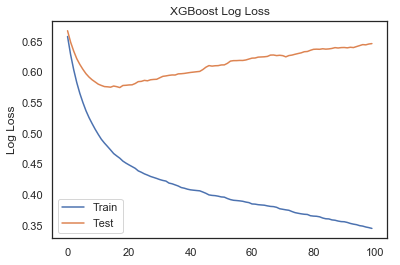

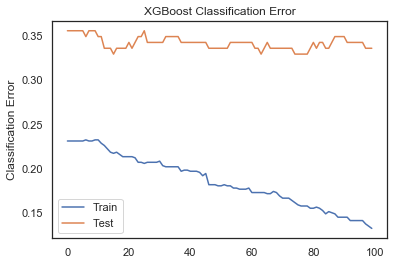

In [110]:
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Training F1: {:.4}%".format(training_accuracy * 100))
print("Validation F1: {:.4}%".format(val_accuracy * 100))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

The log loss and classification errors were captured and graphed, and they support the hypothesis of over-fitting. To remediate this, I will apply an early stopping parameter, using 10 (10%) to restrict XGBoost to the models that restrict over-fitting.

In [122]:
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
    'early_stopping_rounds':[10],
}

[0]	validation_0-error:0.231061	validation_0-logloss:0.657779	validation_1-error:0.355263	validation_1-logloss:0.667098
[1]	validation_0-error:0.231061	validation_0-logloss:0.628166	validation_1-error:0.355263	validation_1-logloss:0.648487
[2]	validation_0-error:0.231061	validation_0-logloss:0.603697	validation_1-error:0.355263	validation_1-logloss:0.63402
[3]	validation_0-error:0.231061	validation_0-logloss:0.582693	validation_1-error:0.355263	validation_1-logloss:0.621573
[4]	validation_0-error:0.231061	validation_0-logloss:0.565078	validation_1-error:0.355263	validation_1-logloss:0.612232
[5]	validation_0-error:0.231061	validation_0-logloss:0.550204	validation_1-error:0.355263	validation_1-logloss:0.604216
[6]	validation_0-error:0.232323	validation_0-logloss:0.536821	validation_1-error:0.348684	validation_1-logloss:0.597119
[7]	validation_0-error:0.231061	validation_0-logloss:0.525555	validation_1-error:0.355263	validation_1-logloss:0.591612
[8]	validation_0-error:0.231061	validatio

[69]	validation_0-error:0.169192	validation_0-logloss:0.377266	validation_1-error:0.335526	validation_1-logloss:0.627158
[70]	validation_0-error:0.166667	validation_0-logloss:0.376391	validation_1-error:0.335526	validation_1-logloss:0.626549
[71]	validation_0-error:0.166667	validation_0-logloss:0.375493	validation_1-error:0.335526	validation_1-logloss:0.624589
[72]	validation_0-error:0.166667	validation_0-logloss:0.374769	validation_1-error:0.335526	validation_1-logloss:0.626685
[73]	validation_0-error:0.164141	validation_0-logloss:0.372727	validation_1-error:0.335526	validation_1-logloss:0.62746
[74]	validation_0-error:0.161616	validation_0-logloss:0.370948	validation_1-error:0.328947	validation_1-logloss:0.628804
[75]	validation_0-error:0.159091	validation_0-logloss:0.369922	validation_1-error:0.328947	validation_1-logloss:0.630005
[76]	validation_0-error:0.157828	validation_0-logloss:0.368998	validation_1-error:0.328947	validation_1-logloss:0.631123
[77]	validation_0-error:0.157828	

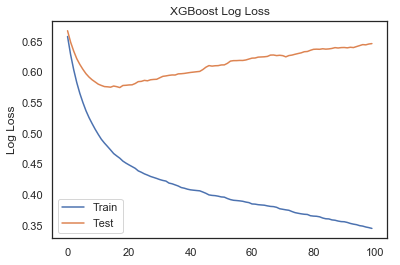

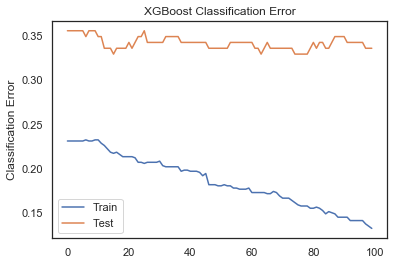

In [123]:
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Training F1: {:.4}%".format(training_accuracy * 100))
print("Validation F1: {:.4}%".format(val_accuracy * 100))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [126]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
    'early_stopping_rounds':[4]
}

In [127]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = f1_score(y_train, training_preds)
val_accuracy = f1_score(y_test, val_preds)

print("")
print("Training F1: {:.4}%".format(training_accuracy * 100))
print("Validation F1: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
early_stopping_rounds: 4
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 100
subsample: 0.7

Training F1: 84.94%
Validation F1: 59.13%


In [128]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [3,6,9],
    'min_child_weight': [1,7],
    'subsample': [0.5, 0.9],
    'n_estimators': [5, 30, 100, 250],
    'early_stopping_rounds':[5]
}

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = f1_score(y_train, training_preds)
val_accuracy = f1_score(y_test, val_preds)

print("")
print("Training F1: {:.4}%".format(training_accuracy * 100))
print("Validation F1: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
early_stopping_rounds: 5
learning_rate: 0.1
max_depth: 3
min_child_weight: 1
n_estimators: 100
subsample: 0.5

Training F1: 85.99%
Validation F1: 57.14%


#### XG Boost Model Summary 
The first model delivered an F1 precision of 87.5%, using default parameters. This was the best performing model so far relative to the other methods used. The model validation F1 was 59.2%. This raised concern about model over-fitting, so I measured and graphed the classification error and log loss, and confirmed this. It appears that epochs 10-15 were the best performing of this exercise. 

To limit over-fitting, I set the early_stopping parameter to 10 and used GridSearch to help select hyperparameters. Model 2 delivered an F1 precision of 86.0%, using learning_rate= 0.1, max_depth=6, min_child_weight=10, n_estimators=100, and subsample= 0.7. The model validation F1 was 57.1%.

Still concerned, I lowered early_stopping to 4, and Model 3 delivered an F1 precision of 84.9%, also using GridSearch, using learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, and subsample=0.7. The model validation F1 was 59.1%.

Finally, I raised the early_stopping to 5 and added multiple options in the parameters. This resulted in the selected model of 86.0% using learning_rate of 0.1, max_depth of 3, min_child_weight of 1, 100 estimators, and subsample=0.5. The validation F1 was 57.1%

## Analysis and Conclusions

After reviewing 16 models, the best performing model for this analysis was the XG Boost. The F1 scores can be summarized as follows:

Logistic Regression: (0.667)
K-Nearest Neighbors: (0.571,
                     0.575,
                     0.575,
                     0.600)
Decision Tree:       (0.541,
                     0.607,
                     0.772,
                     0.654)
Random Forest:       (0.614,
                     0.574,
                     0.571)
XG Boost:            (0.875,
                     0.860,
                     0.849
                     0.860)

While this last model may be overfitting, the XG Boost model was the best performing model for this analysis. Through analysis of the classification errors and log loss, XG Boost in its second epoch delivered a strong predictive signal. However, given the over-fitting issue with XG Boost, Decision Tree may be the most appropriate model to use if this were applied to other data sets. 

In [129]:
dtree.feature_importances_

array([0.05479858, 0.        , 0.        , 0.79350684, 0.06409049,
       0.06430943, 0.02329466])

In [ ]:
'Glucose', 'A1cNorm', 'A1cDia', 'Glucose BMI', 'Glucose BMIHigh',
       'A1cNorm DiabetesPedigreeFunction_log', 'GluNorm PregNorm'